In [1]:
from pathlib import Path
from subprocess import Popen
import numpy as np
import matplotlib.pyplot as plt
import shutil
from Bio import SeqIO
from Bio.Phylo.PhyloXML import Phyloxml
from Bio.Phylo import PhyloXMLIO
from cen_detect_hor.distance import distance_values
from cen_detect_hor.showHOR import show_hor, show_hors, show_hor_tree
from cen_detect_hor.featureUtils import BED_file_to_features, feature_to_seq, remove_overlapping_features
from cen_detect_hor.parallel_distance import build_seqs_distance_matrix_by_chunks, FileSystemChunkStore
from cen_detect_hor.hor_tree import phylogeny_to_hor_tree
from cen_detect_hor.clustering_to_phylogeny import clustering_to_phylogeny
from cen_detect_hor.mixed_direction_hors import find_inversion_loops
from cen_detect_hor.compare_phylogenies import phylogenies_equal

In [2]:
data_path = "data/casohormultiple"
fasta_file_name = "PAB.chrX_hap1_hsaX"

In [3]:
references = {seq.id : seq for seq in SeqIO.parse(f"{data_path}/{fasta_file_name}.fasta", "fasta")}

In [4]:
reference_seq_id = [*references][0]

In [5]:
monomers_as_features = BED_file_to_features(f"{data_path}/final_decomposition.bed")

In [6]:
monomers_as_features = remove_overlapping_features(
    features=monomers_as_features,
    expected_feature_size=171,
    max_allowed_overlap_fraction=0.25
)

Kept sequence feature chrX_hap1_hsaX:58029629-68223789[1515128:1515296](-) overlapping (25 bps) with sequence feature chrX_hap1_hsaX:58029629-68223789[1515028:1515153](-).
Kept sequence feature chrX_hap1_hsaX:58029629-68223789[7490172:7490343](-) overlapping (1 bps) with sequence feature chrX_hap1_hsaX:58029629-68223789[7490001:7490173](-).
Kept sequence feature chrX_hap1_hsaX:58029629-68223789[8865060:8865232](-) overlapping (1 bps) with sequence feature chrX_hap1_hsaX:58029629-68223789[8864890:8865061](-).
Kept sequence feature chrX_hap1_hsaX:58029629-68223789[9140189:9140360](+) overlapping (1 bps) with sequence feature chrX_hap1_hsaX:58029629-68223789[9140019:9140190](+).
Kept sequence feature chrX_hap1_hsaX:58029629-68223789[9415105:9415277](+) overlapping (1 bps) with sequence feature chrX_hap1_hsaX:58029629-68223789[9414936:9415106](+).
Kept sequence feature chrX_hap1_hsaX:58029629-68223789[9485125:9485297](-) overlapping (1 bps) with sequence feature chrX_hap1_hsaX:58029629-682

/Users/miguel/git/CENdetectHOR_lib/env/lib/python3.9/site-packages/Bio/SeqFeature.py:260: BiopythonDeprecationWarning: Please use .location.ref rather than .ref
  warnings.warn(


In [7]:
# # sample monomers for testing purposes (comment out for complete analysis)

# sample_size = 20
# num_samples = 5

# sample_page = len(monomers_as_features) // num_samples
# sample_offset = (sample_page - sample_size) // 2

# def slice_seq(seq, position, length):
#     return seq[position : position + length]

# monomers_as_features = [
#     monomer
#     for sample_index in range(num_samples)
#     for monomer in slice_seq(monomers_as_features, sample_index * sample_page + sample_offset, sample_size)
# ]

In [8]:
monomers_as_seqs = [feature_to_seq(feature, references) for feature in monomers_as_features]

In [9]:

distance_matrix_path = f"{data_path}/distances.npy"
try :
    monomer_dists = np.load(distance_matrix_path)
except IOError:
    chunk_path = f"{data_path}/submatrices_32"
    Path(chunk_path).mkdir(parents=True, exist_ok=True)
    monomer_dists = build_seqs_distance_matrix_by_chunks(
        monomers_as_seqs, num_chunks=32,
        chunk_store=FileSystemChunkStore(chunk_path + "/piece_{row}_{col}")
    )
    with open(f"{data_path}/distances.npy", 'wb') as f:
        np.save(f, monomer_dists)
    shutil.rmtree(chunk_path, ignore_errors=True)

In [10]:
# dist_values = distance_values(monomer_dists)
# plt.hist(dist_values, bins=int(max(dist_values)))

In [11]:
# plt.matshow(monomer_dists)

In [12]:
phylogeny = clustering_to_phylogeny(
    dist_matrix=monomer_dists,
    items_as_seq_features=monomers_as_features,
    seq_references=references
).phylogeny

In [13]:
phyloXml = Phyloxml(phylogenies=[phylogeny], attributes=None)
PhyloXMLIO.write(phyloXml, f"{data_path}/monomer_phylogeny.xml")

1

In [14]:
hor_tree = phylogeny_to_hor_tree(phylogeny)

/Users/miguel/git/CENdetectHOR_lib/env/lib/python3.9/site-packages/Bio/Phylo/PhyloXML.py:985: PhyloXMLWarning: String monomer_clade_seq doesn't match the given regexp
  _check_str(ref, self.re_ref.match)


In [15]:
inversion_loops = find_inversion_loops(seq_features=monomers_as_features)
[str(loop_inSeq) for loop_inSeq in inversion_loops]

/Users/miguel/git/CENdetectHOR_lib/env/lib/python3.9/site-packages/Bio/SeqFeature.py:231: BiopythonDeprecationWarning: Please use .location.strand rather than .strand
  warnings.warn(


[]

In [16]:
phyloXml = Phyloxml(phylogenies=[hor_tree.as_phyloxml], attributes=None)
PhyloXMLIO.write(phyloXml, f"{data_path}/HORs.xml")

1

In [17]:
phyloXml = Phyloxml(phylogenies=[phylogeny, hor_tree.as_phyloxml], attributes=None)
PhyloXMLIO.write(phyloXml, f"{data_path}/monomer_phylogeny_and_HORs.xml")

2

In [18]:
hor_tree_discrete = phylogeny_to_hor_tree(phylogeny, discrete_sorted_levels=True)

In [19]:
phyloXml = Phyloxml(phylogenies=[hor_tree_discrete.as_phyloxml], attributes=None)
PhyloXMLIO.write(phyloXml, f"{data_path}/HORs_discrete.xml")

1

In [20]:
Popen(["./check.sh"], cwd=data_path).wait()

0

In [21]:
phylogenies_equal(hor_tree.as_phyloxml, hor_tree_discrete.as_phyloxml, check_branch_lengths=False)

False

Subtree: []


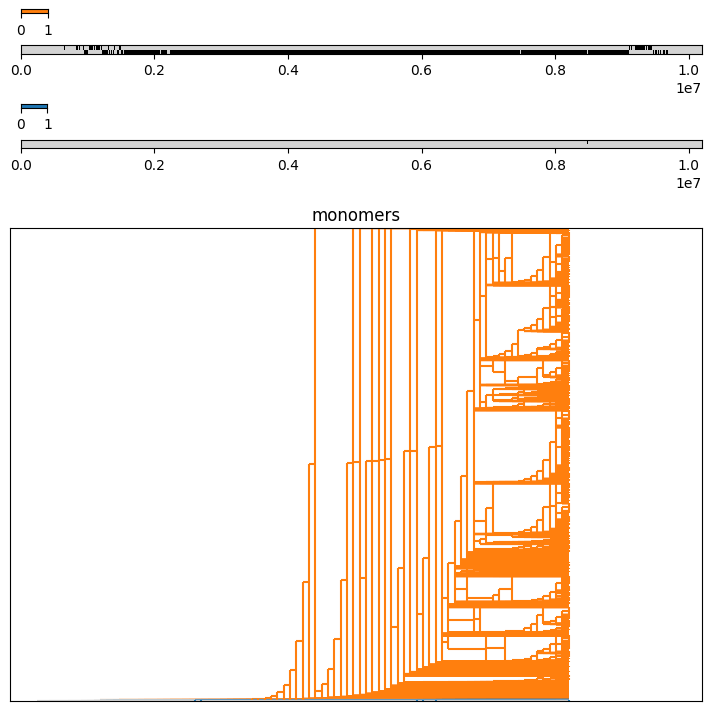

Subtree: [1]


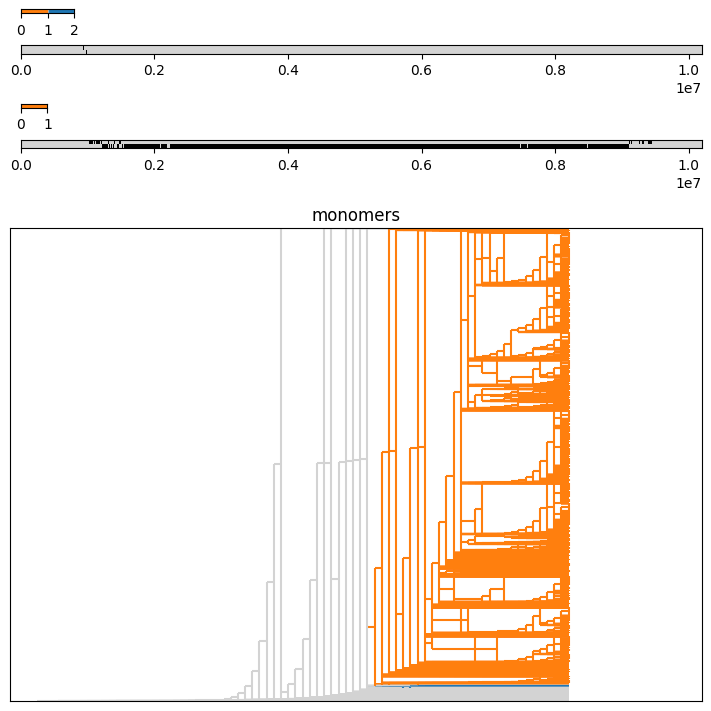

Subtree: [1, 2]


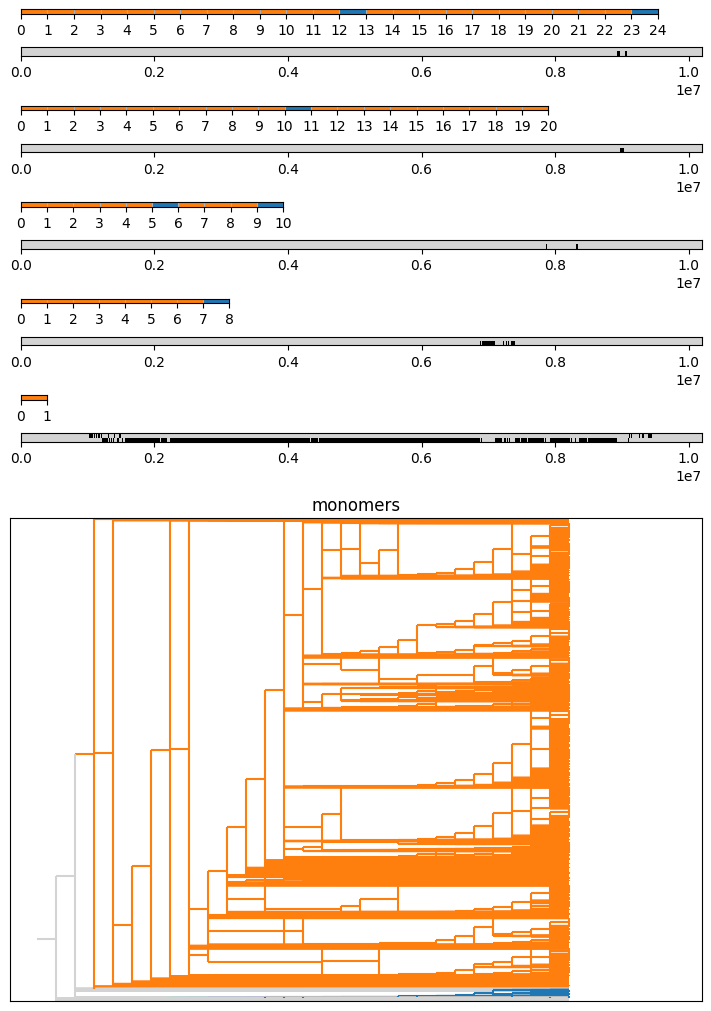

Subtree: [1, 2, 1]


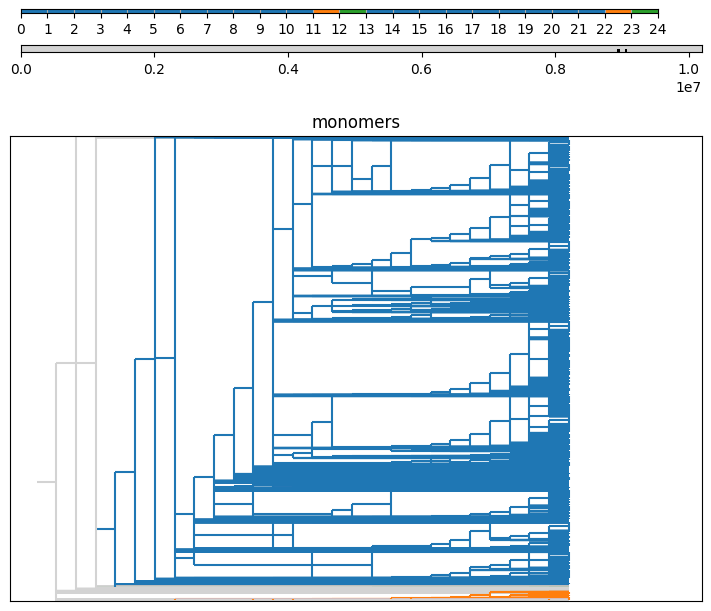

Subtree: [1, 2, 1, 1]


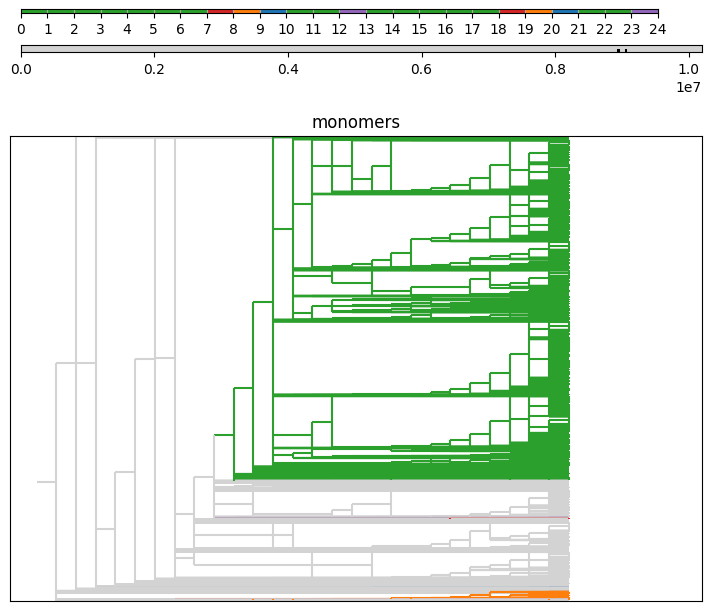

Subtree: [1, 2, 1, 1, 1]


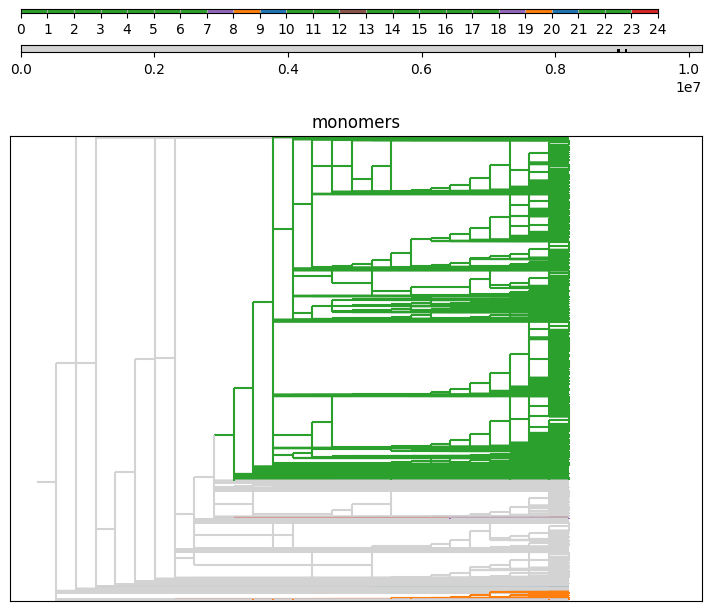

Subtree: [1, 2, 1, 1, 1, 1]


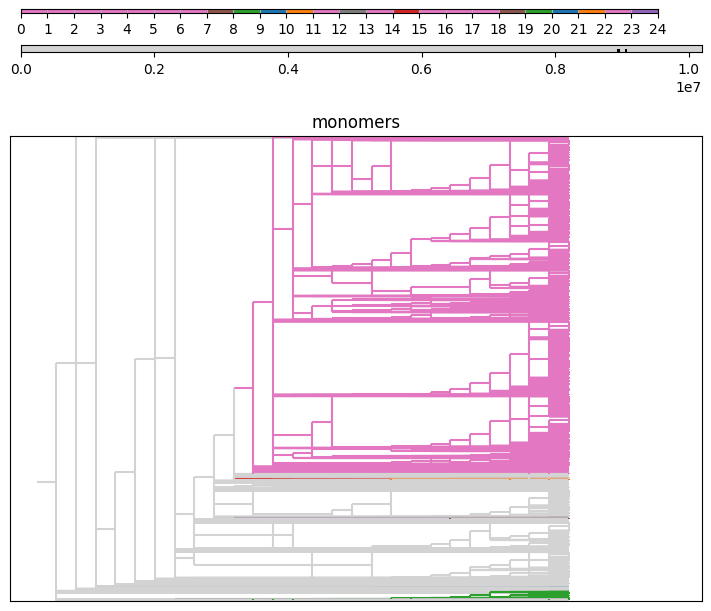

Subtree: [1, 2, 1, 1, 1, 1, 1]


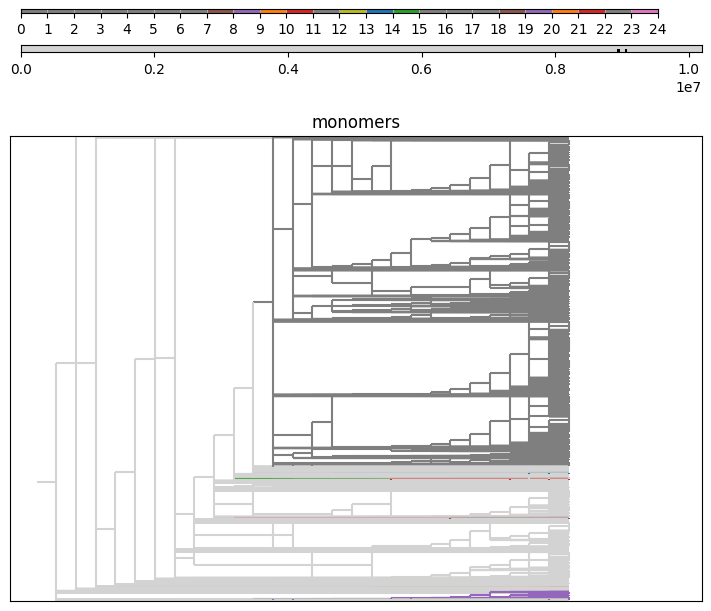

Subtree: [1, 2, 1, 1, 1, 1, 1, 1]


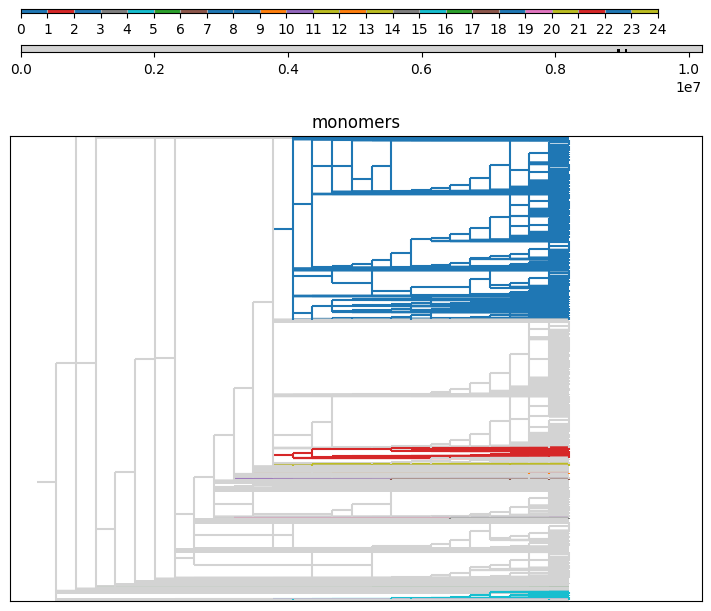

Subtree: [1, 2, 1, 1, 1, 1, 1, 1, 1]


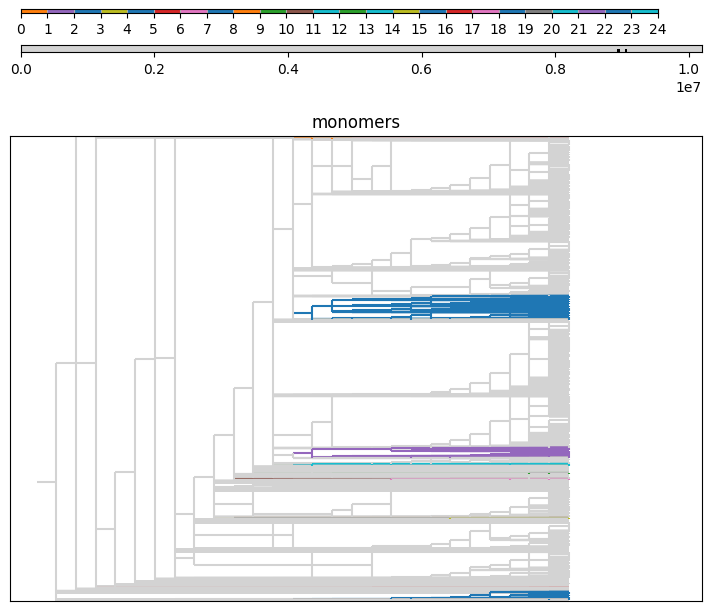

Subtree: [1, 2, 1, 1, 1, 1, 1, 1, 1, 1]


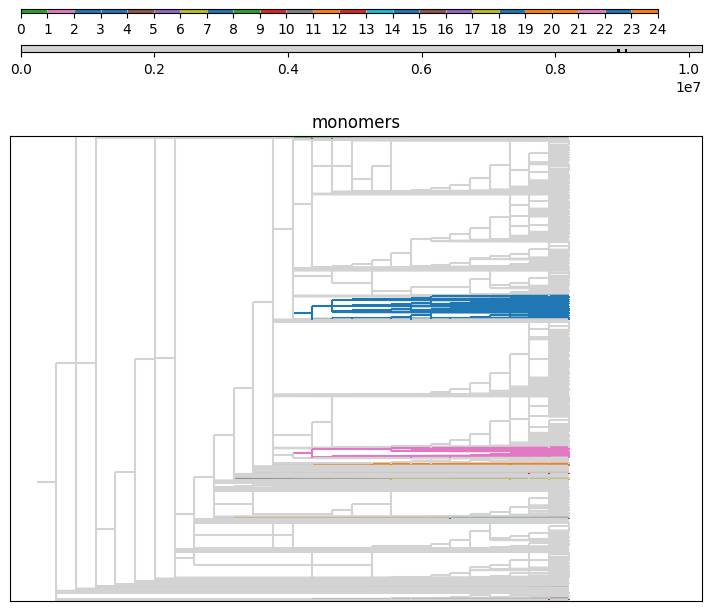

Subtree: [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]


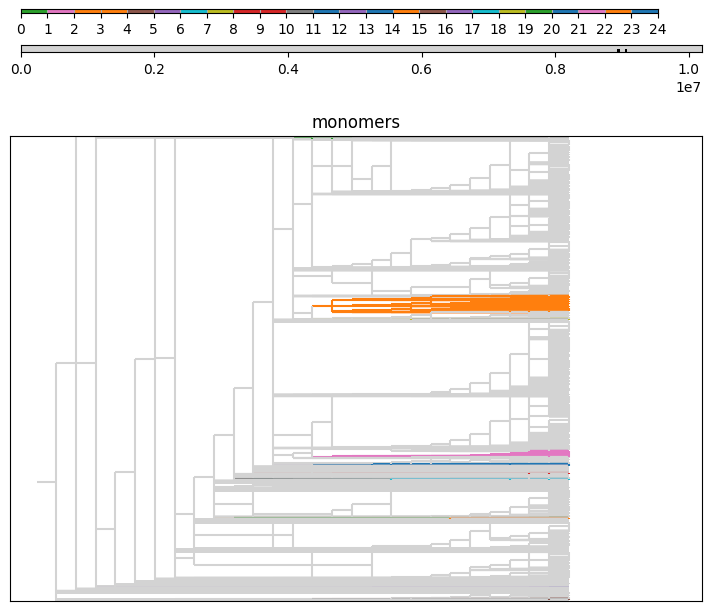

Subtree: [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


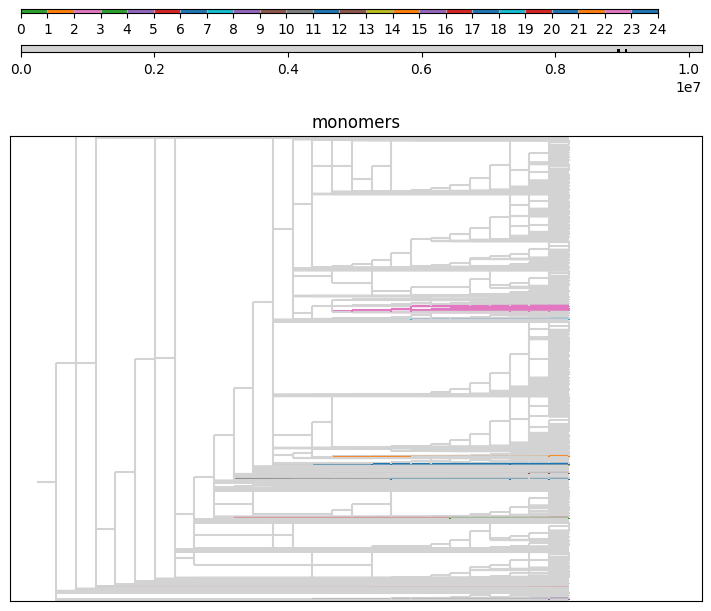

Subtree: [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


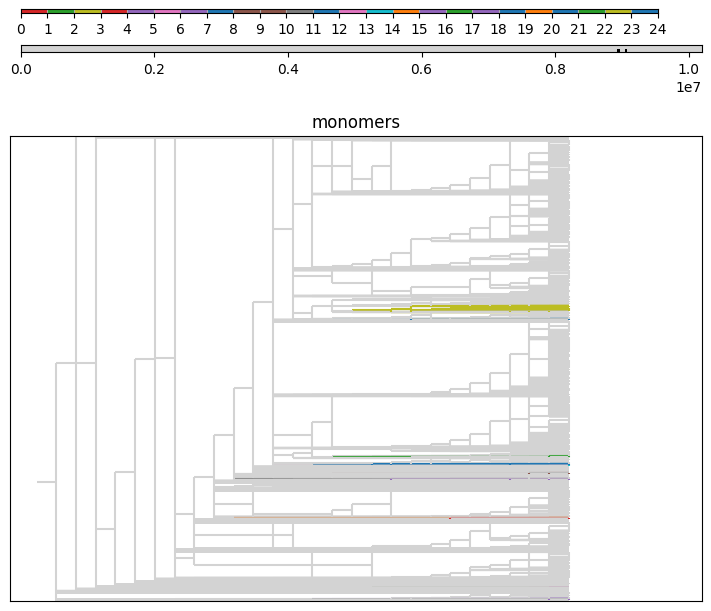

Subtree: [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


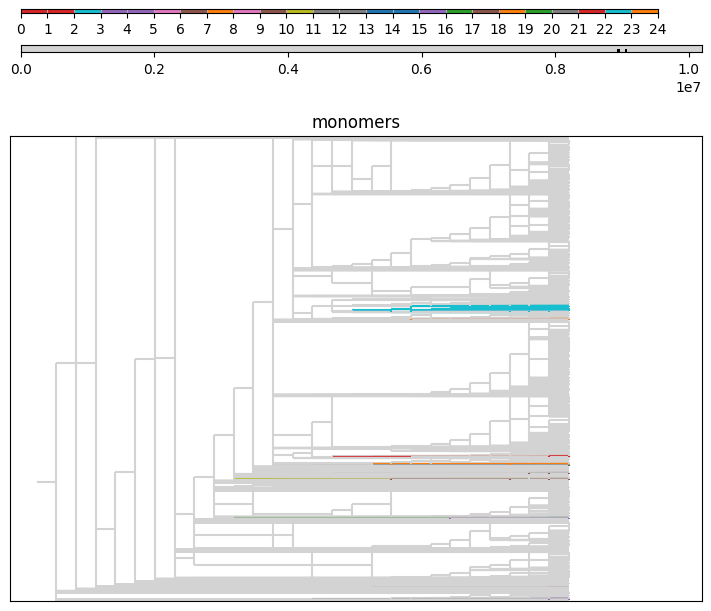

Subtree: [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


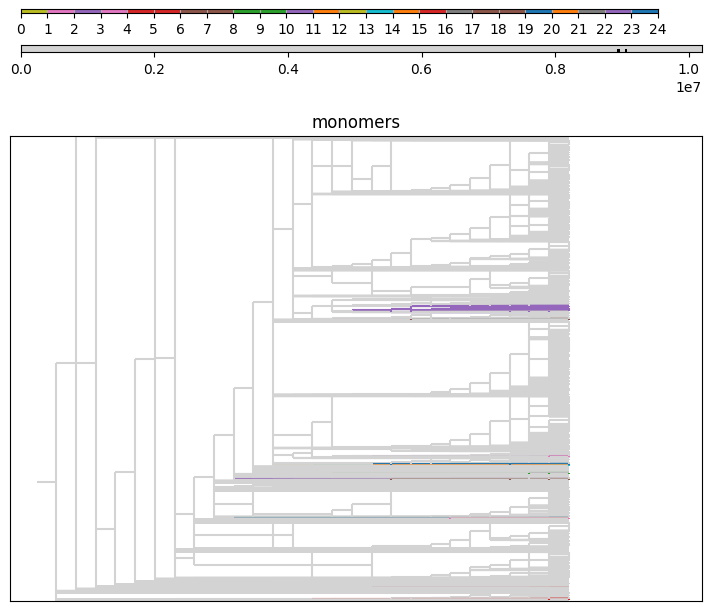

Subtree: [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


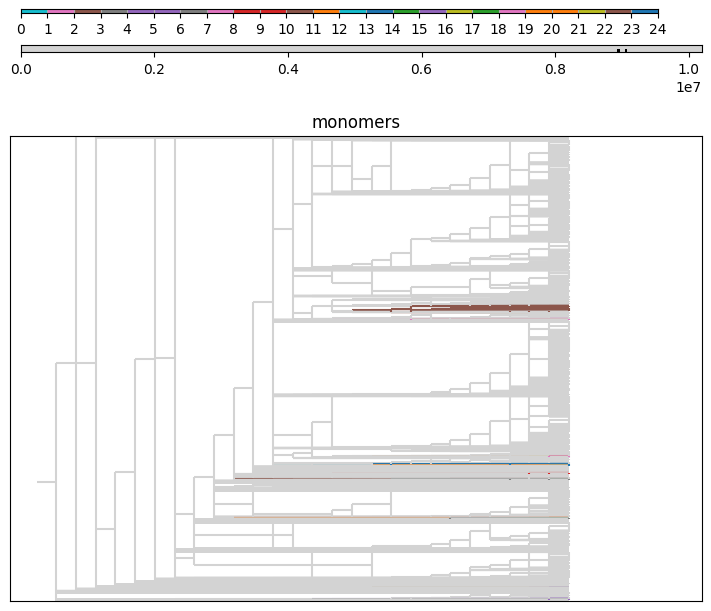

Subtree: [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


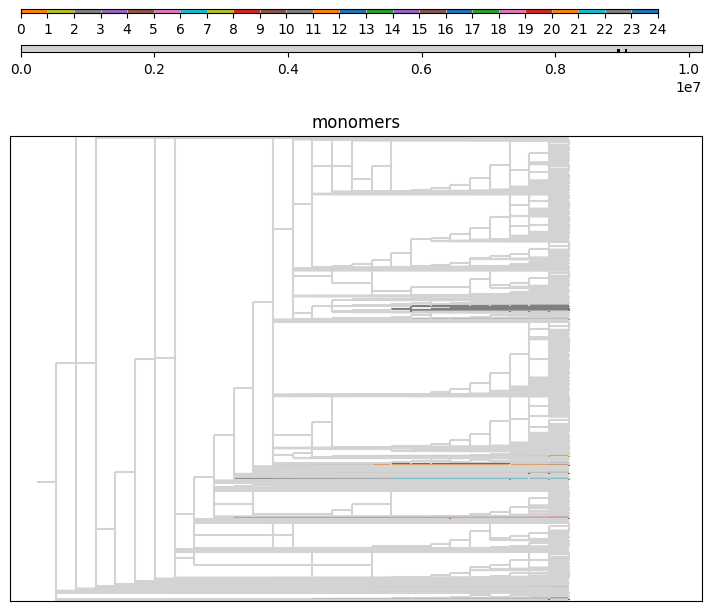

Subtree: [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


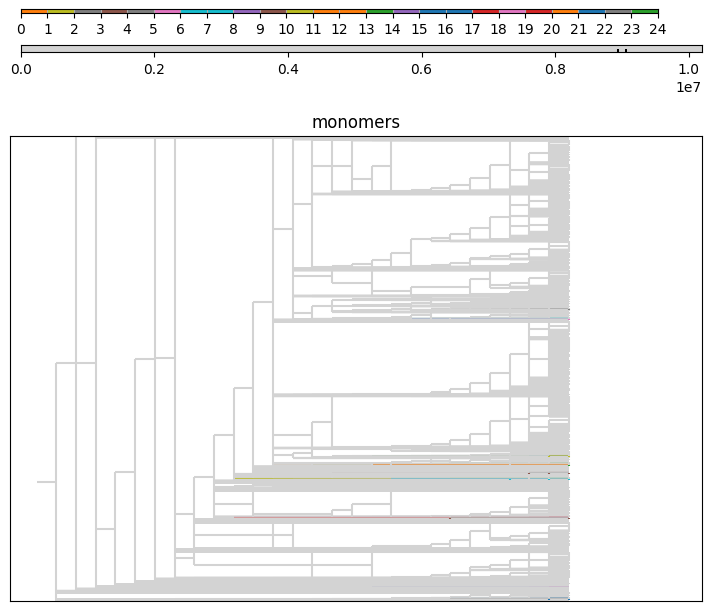

Subtree: [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


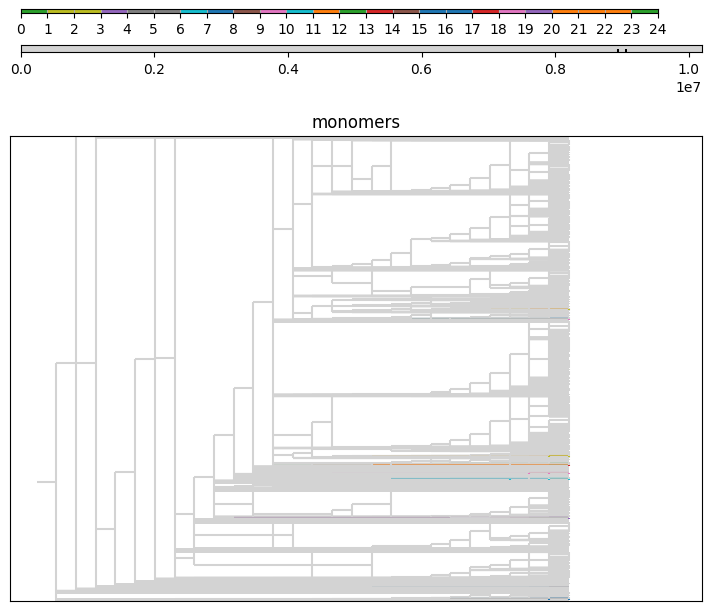

Subtree: [1, 2, 2]


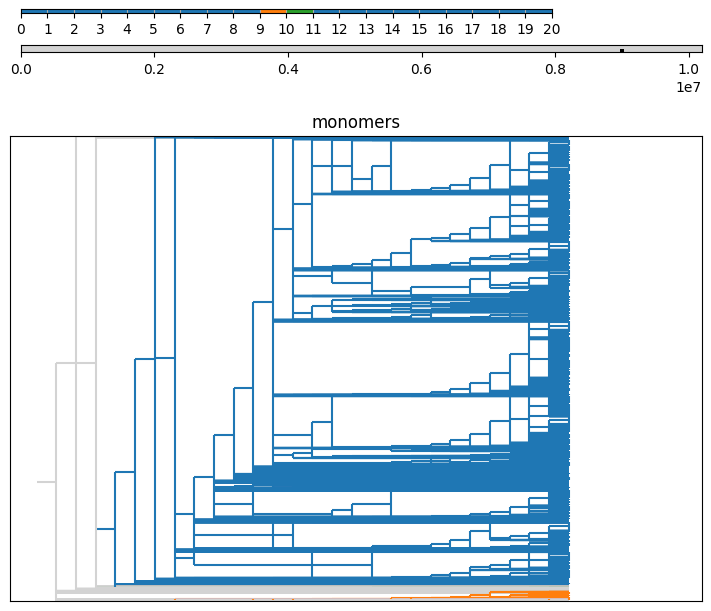

Subtree: [1, 2, 2, 1]


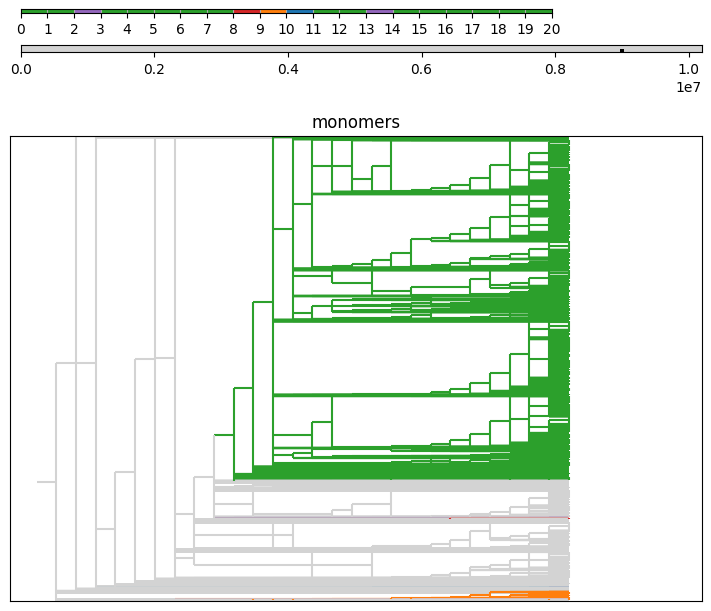

Subtree: [1, 2, 2, 1, 1]


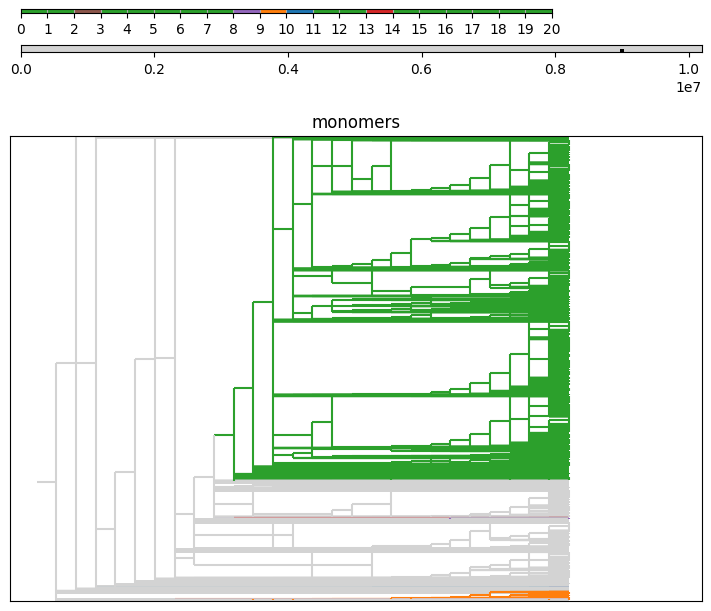

Subtree: [1, 2, 2, 1, 1, 1]


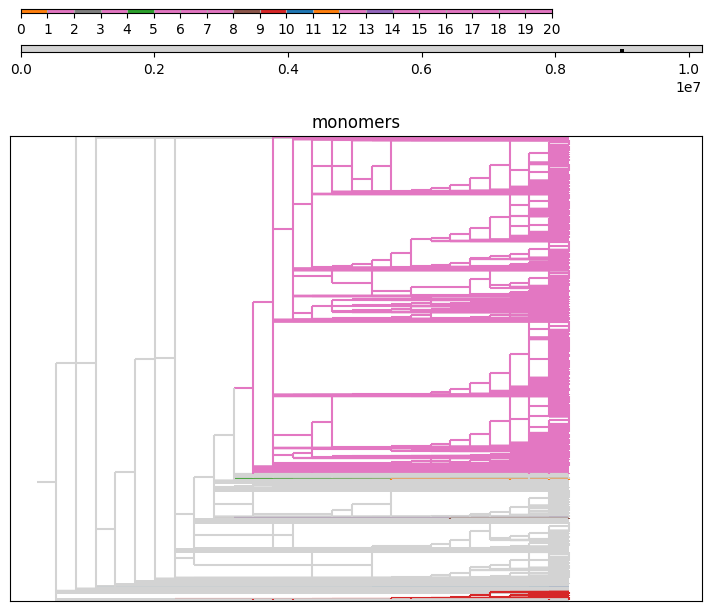

Subtree: [1, 2, 2, 1, 1, 1, 1]


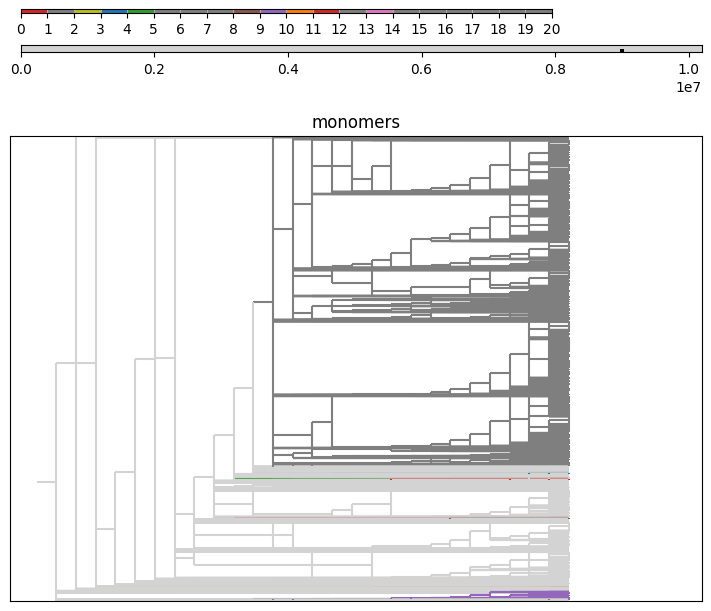

Subtree: [1, 2, 2, 1, 1, 1, 1, 1]


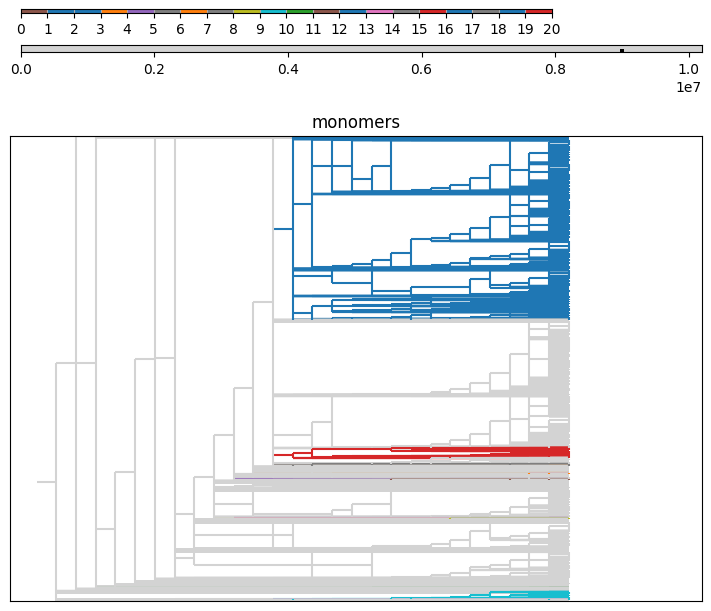

Subtree: [1, 2, 2, 1, 1, 1, 1, 1, 1]


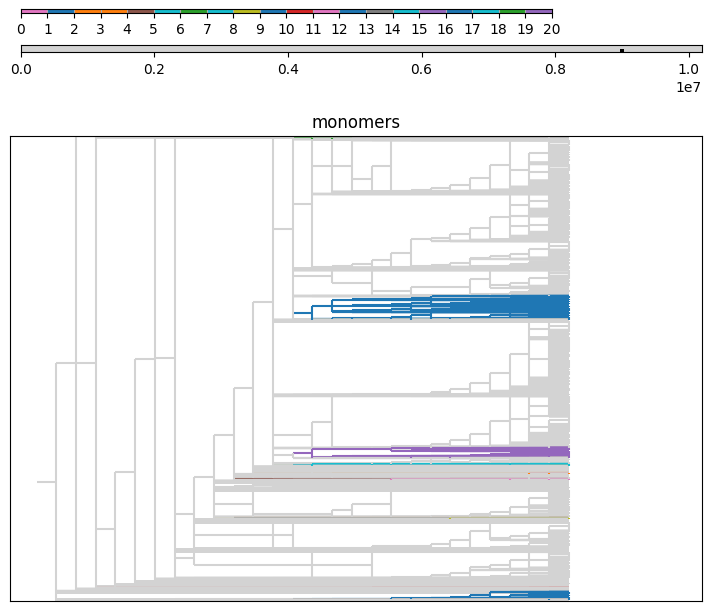

Subtree: [1, 2, 2, 1, 1, 1, 1, 1, 1, 1]


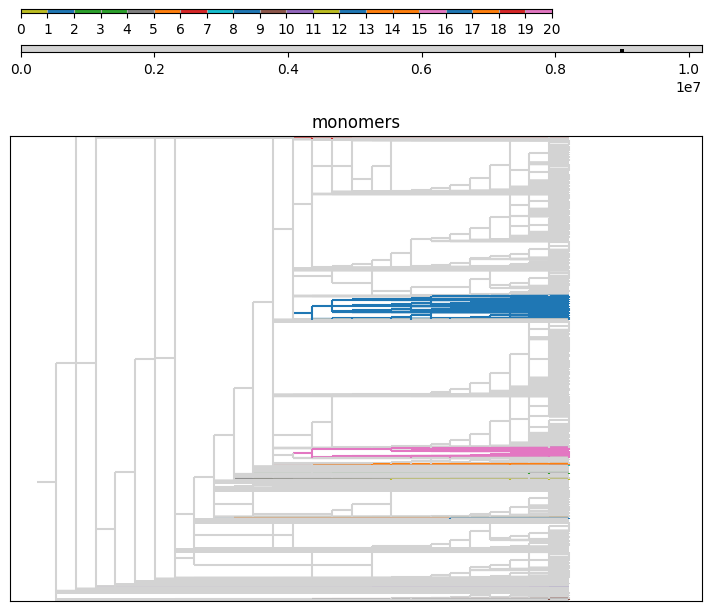

Subtree: [1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1]


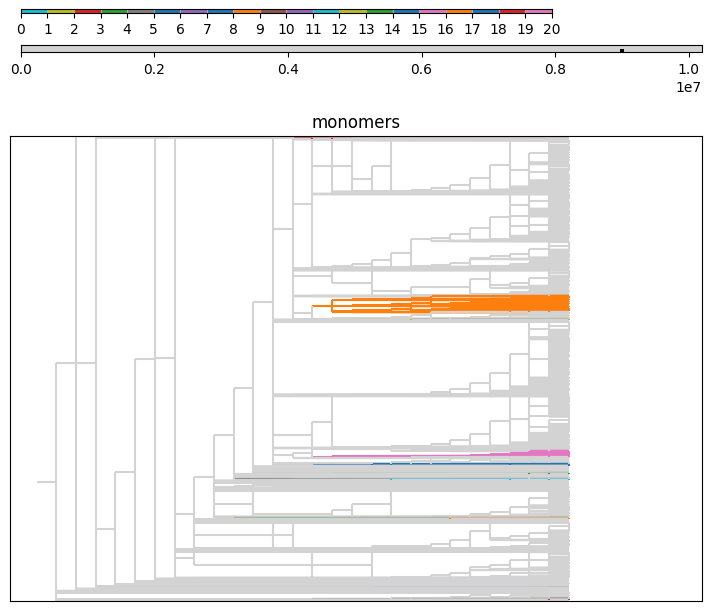

Subtree: [1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]


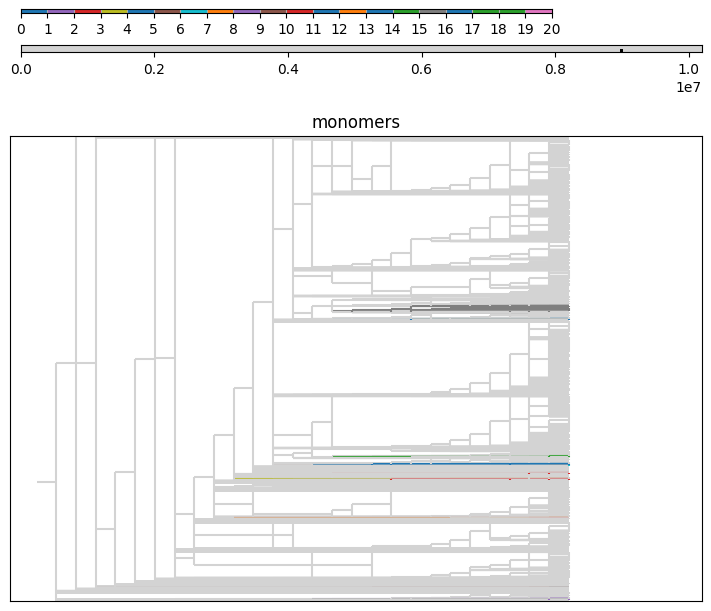

Subtree: [1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


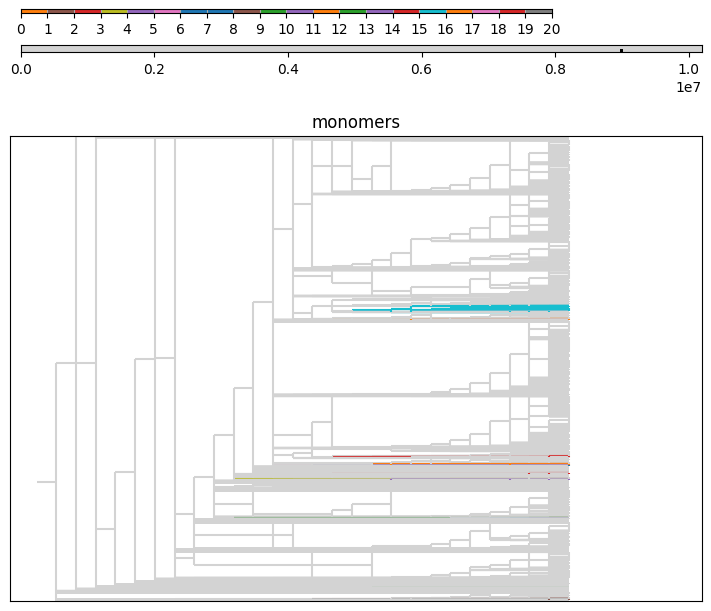

Subtree: [1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


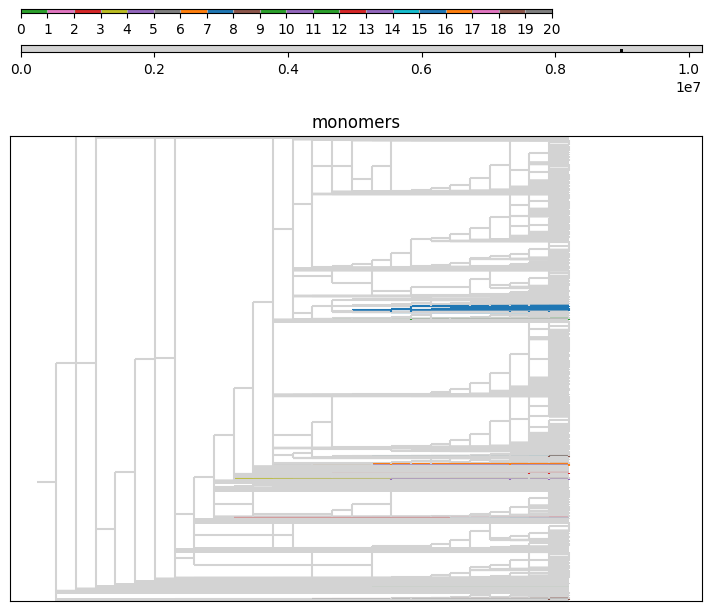

Subtree: [1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


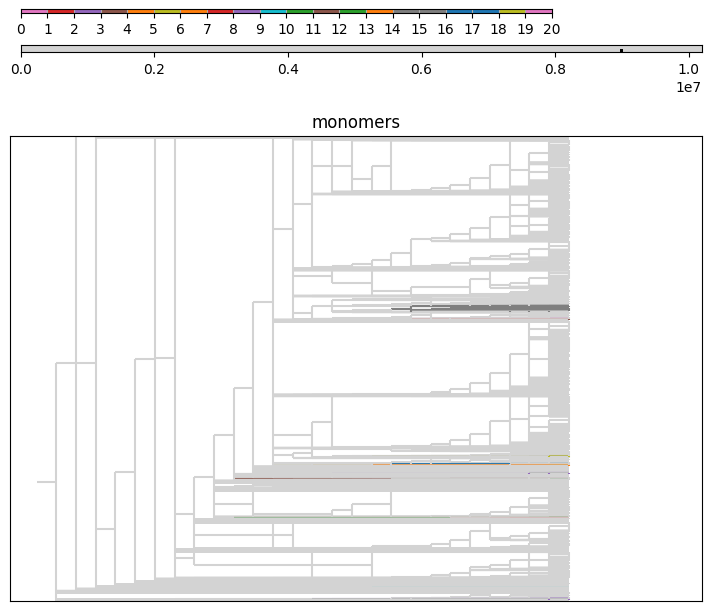

Subtree: [1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


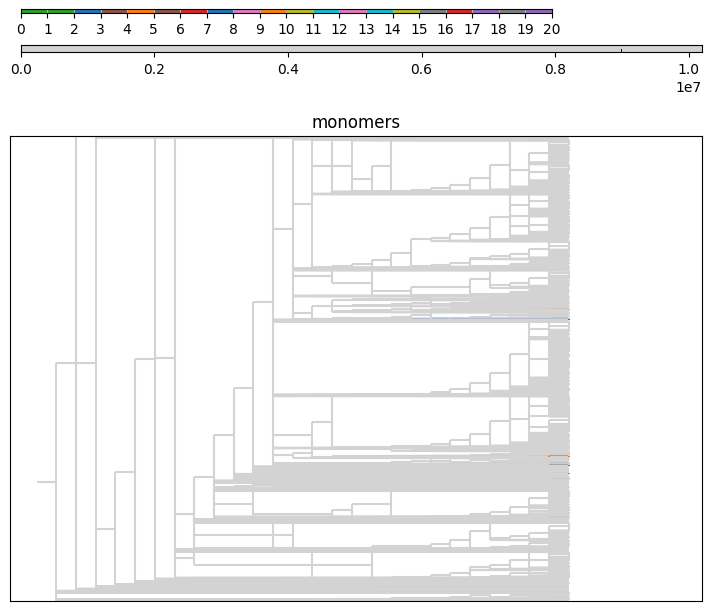

Subtree: [1, 2, 3]


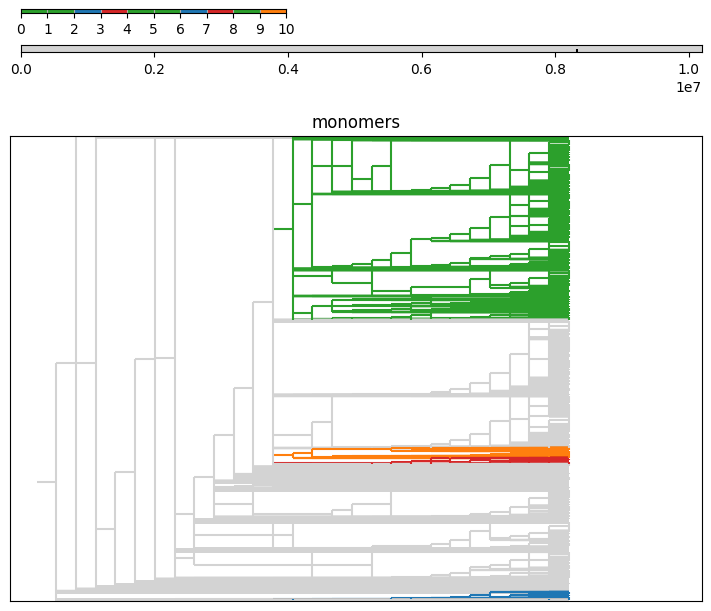

Subtree: [1, 2, 3, 1]


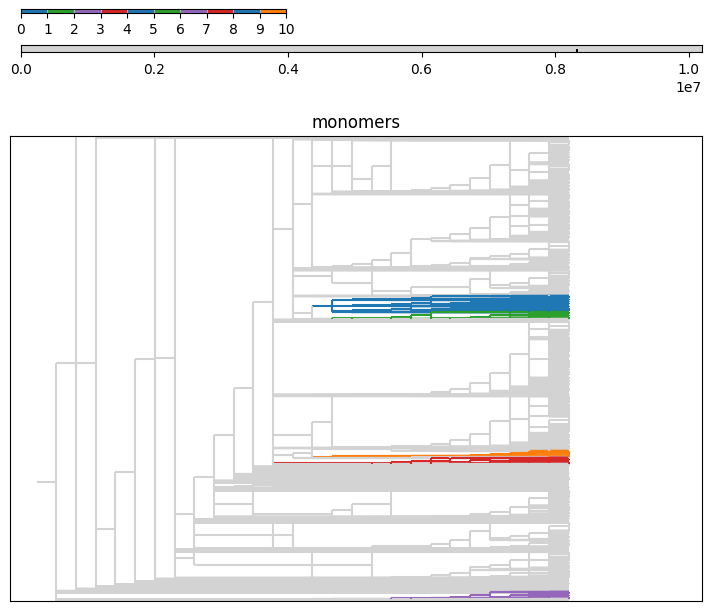

Subtree: [1, 2, 3, 1, 1]


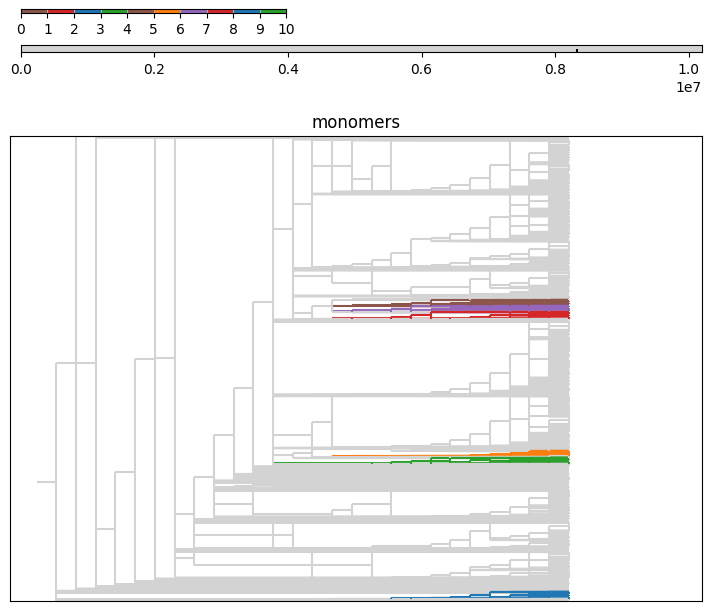

Subtree: [1, 2, 3, 1, 1, 1]


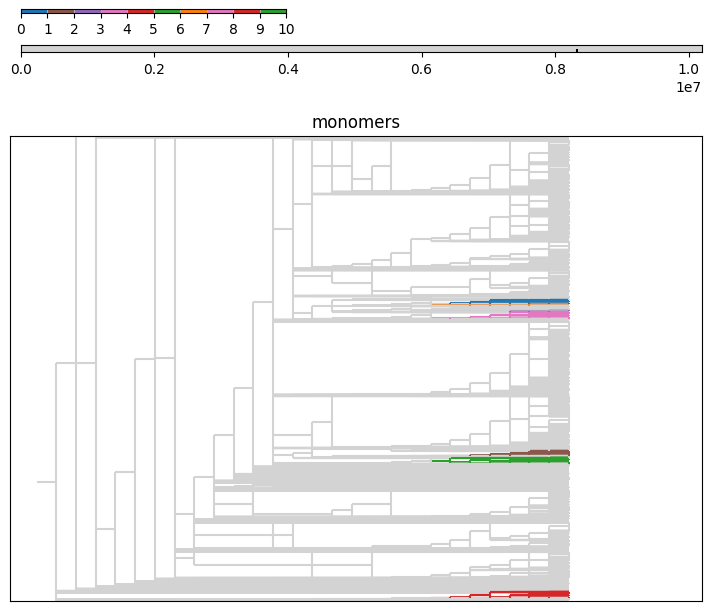

Subtree: [1, 2, 3, 1, 1, 1, 1]


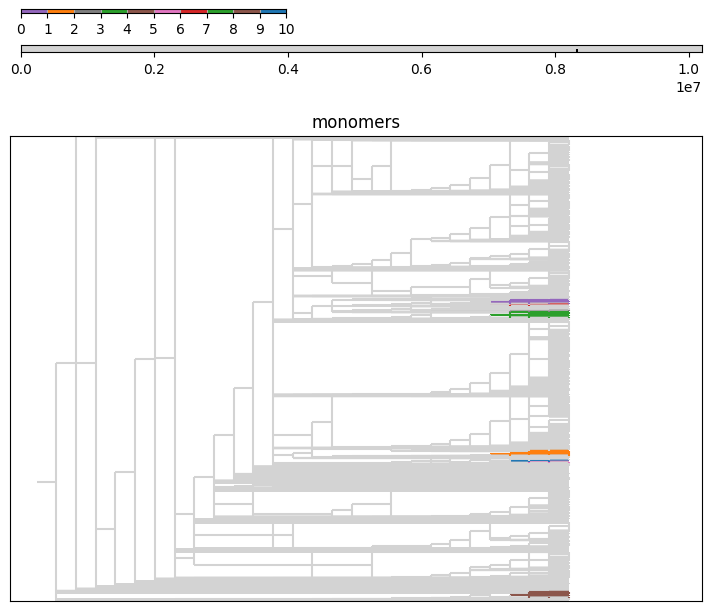

Subtree: [1, 2, 3, 1, 1, 1, 1, 1]


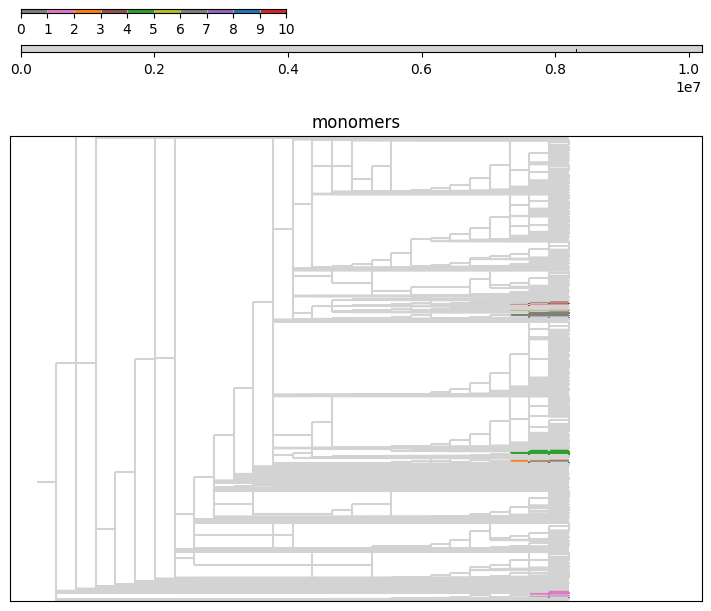

Subtree: [1, 2, 3, 1, 1, 1, 1, 1, 1]


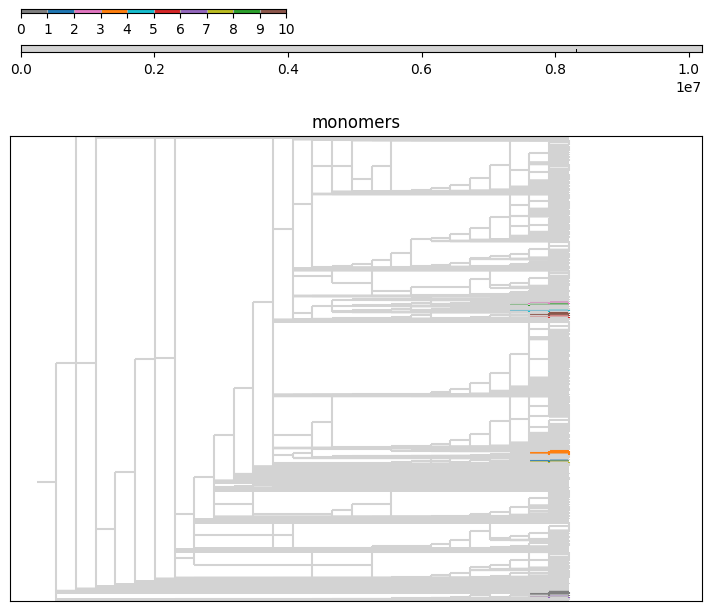

Subtree: [1, 2, 4]


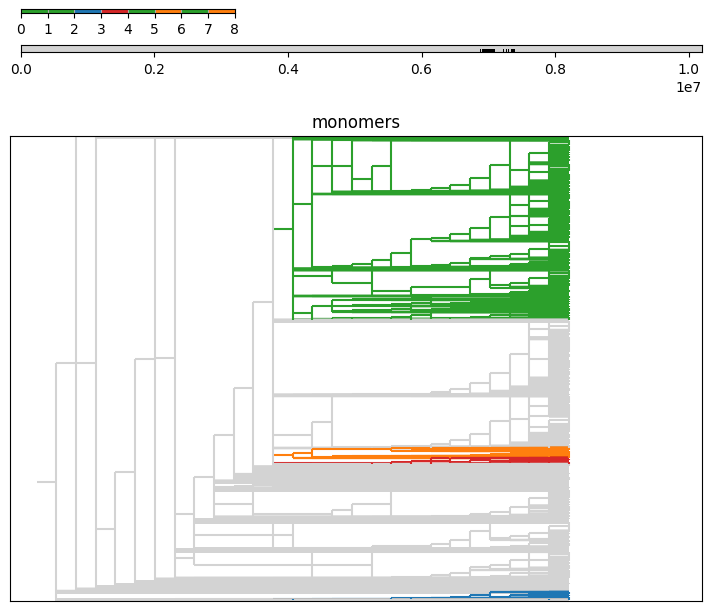

Subtree: [1, 2, 4, 1]


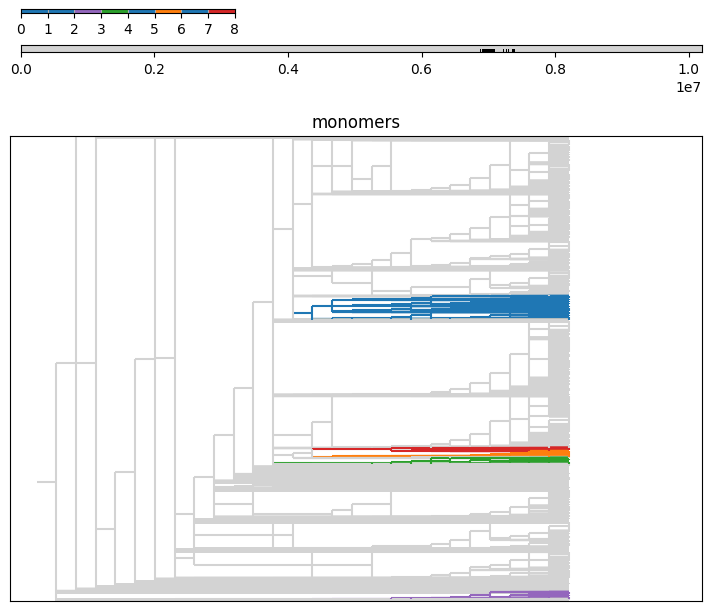

Subtree: [1, 2, 4, 1, 1]


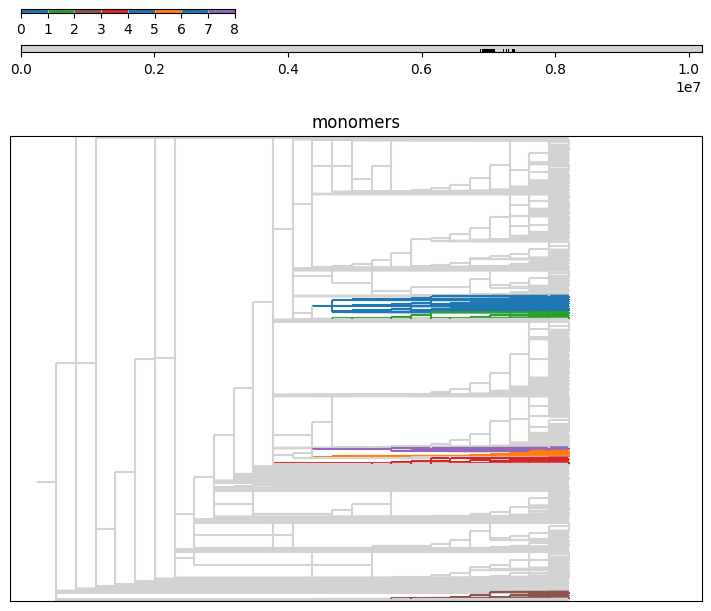

Subtree: [1, 2, 4, 1, 1, 1]


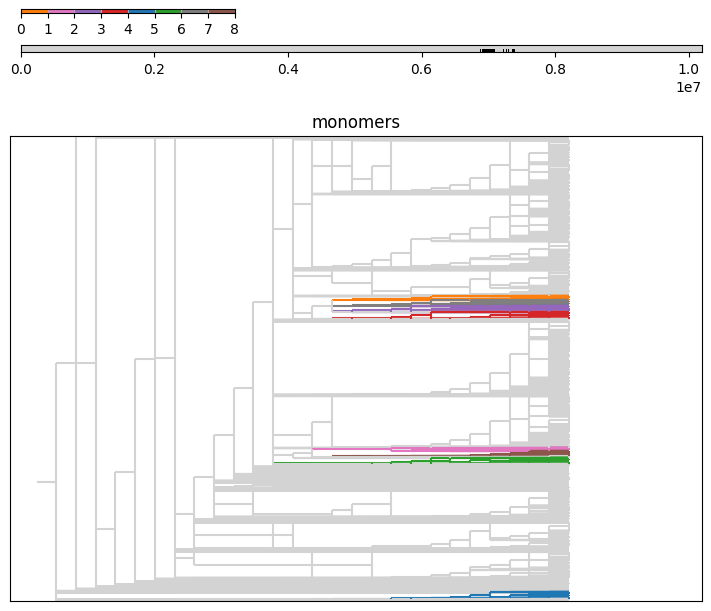

Subtree: [1, 2, 4, 1, 1, 1, 1]


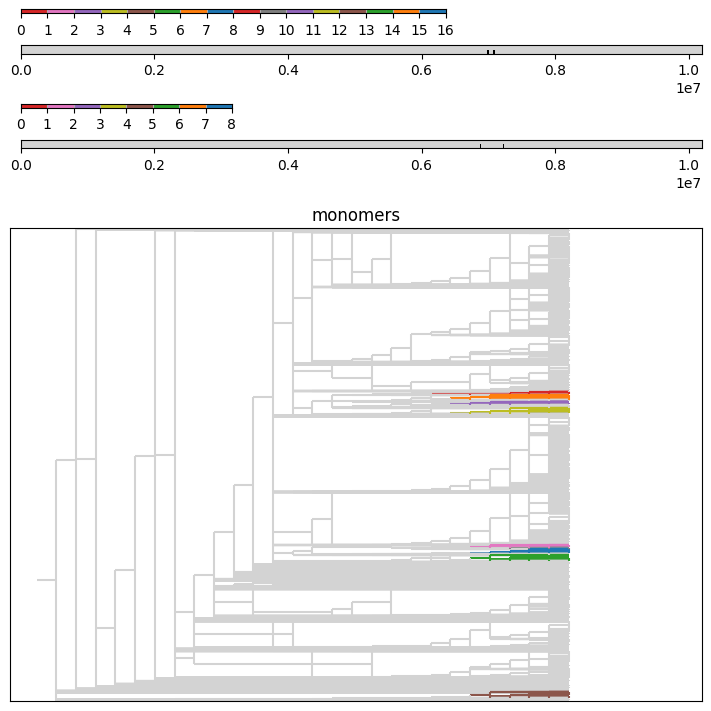

Subtree: [1, 2, 5]


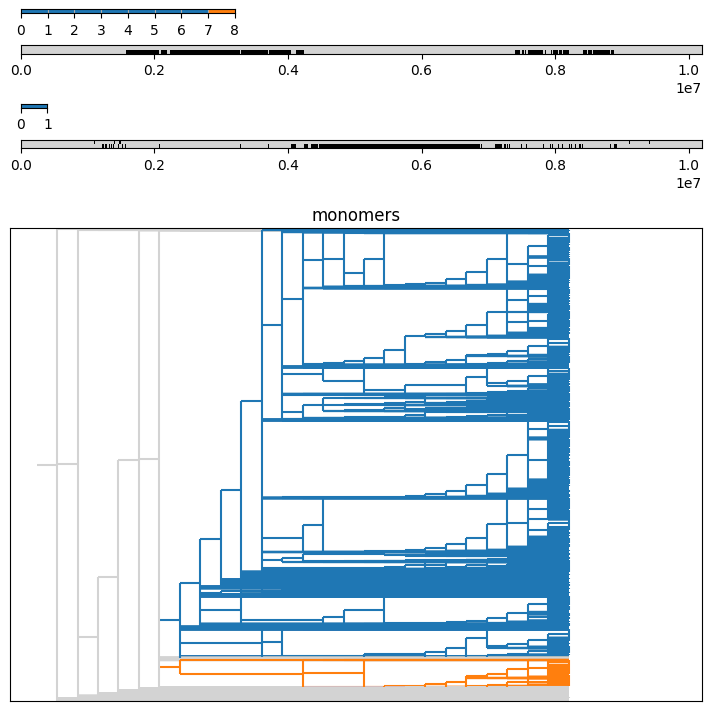

Subtree: [1, 2, 5, 1]


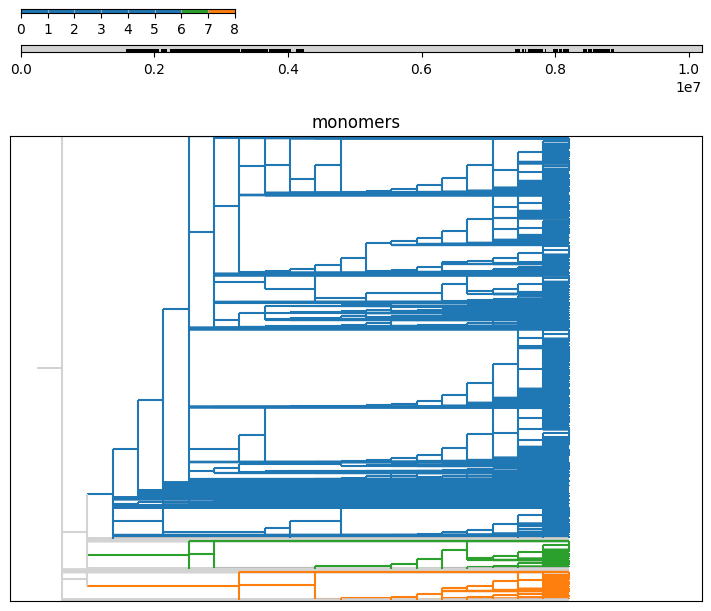

Subtree: [1, 2, 5, 1, 1]


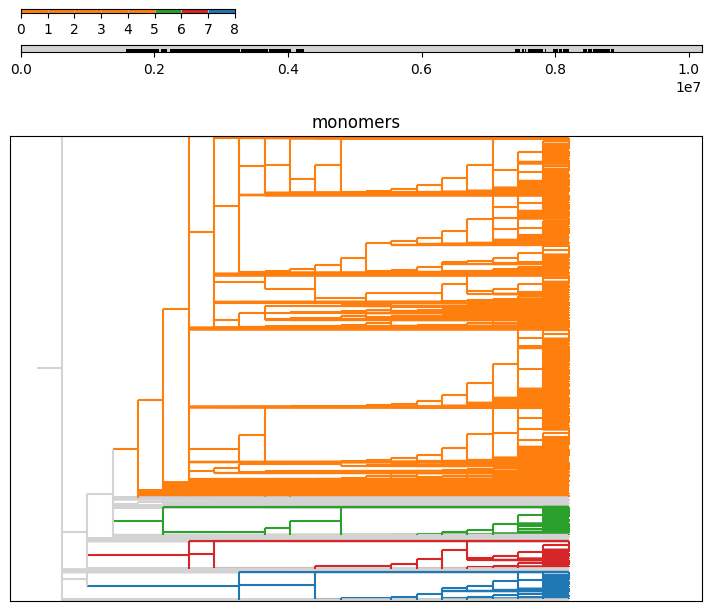

Subtree: [1, 2, 5, 1, 1, 1]


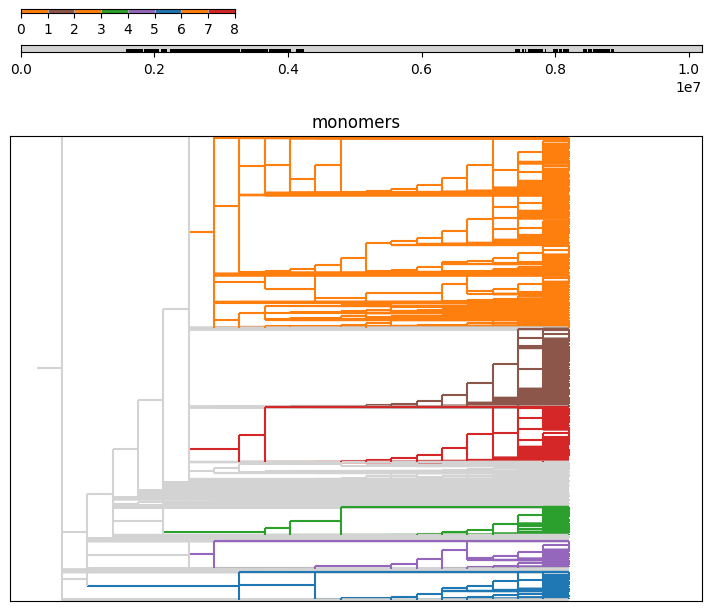

Subtree: [1, 2, 5, 1, 1, 1, 1]


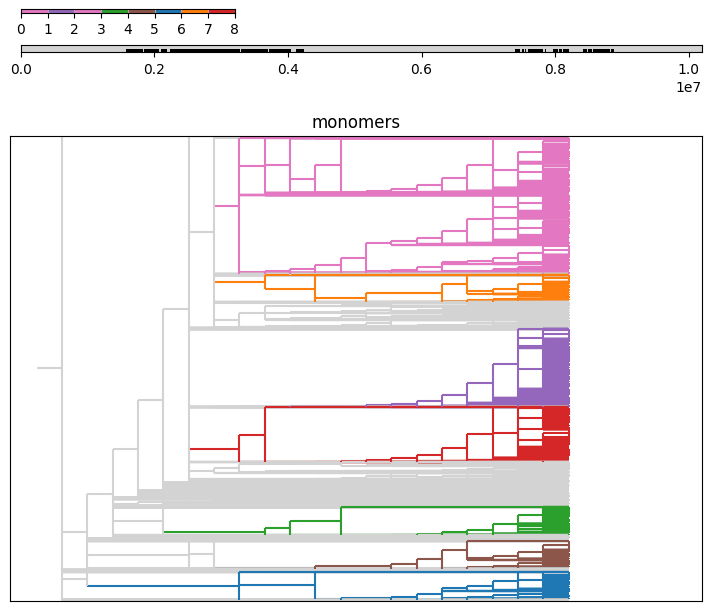

Subtree: [1, 2, 5, 1, 1, 1, 1, 1]


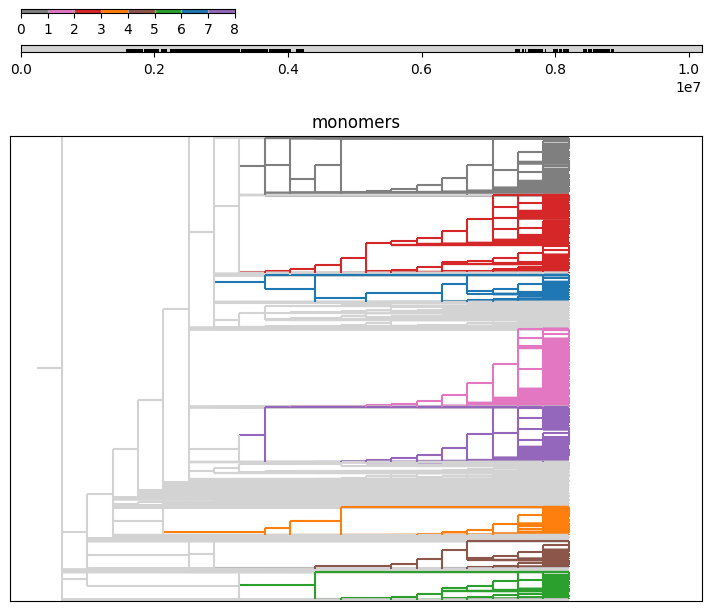

Subtree: [1, 2, 5, 1, 1, 1, 1, 1, 1]


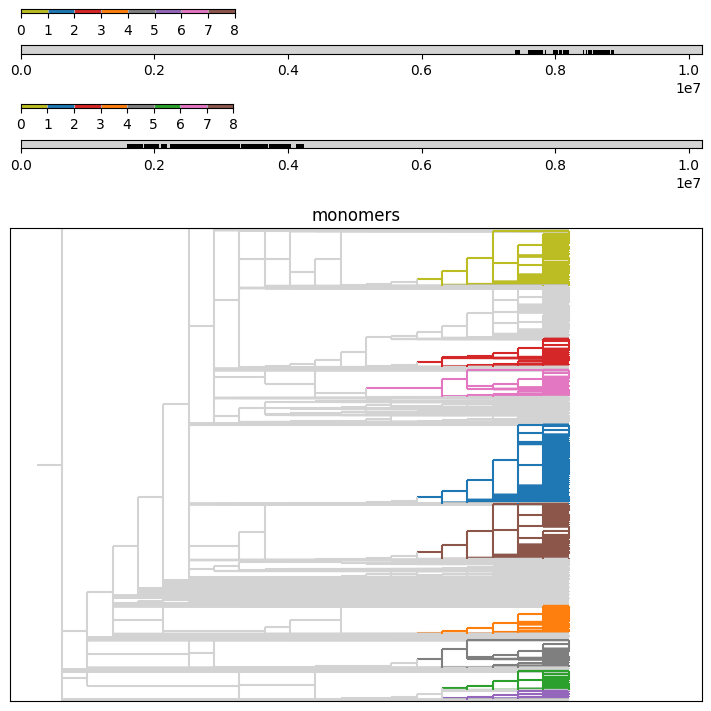

Subtree: [1, 2, 5, 1, 1, 1, 1, 1, 1, 1]


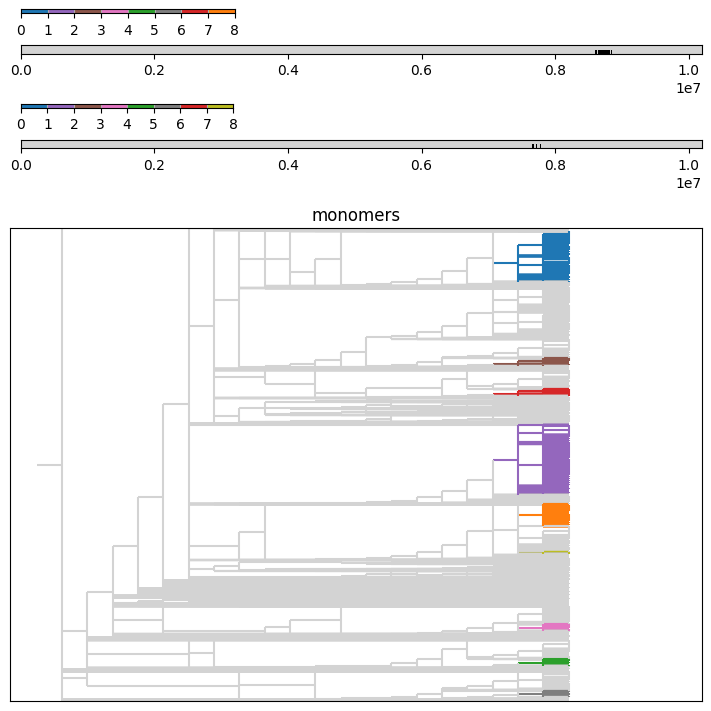

Subtree: [1, 2, 5, 1, 1, 1, 1, 1, 1, 2]


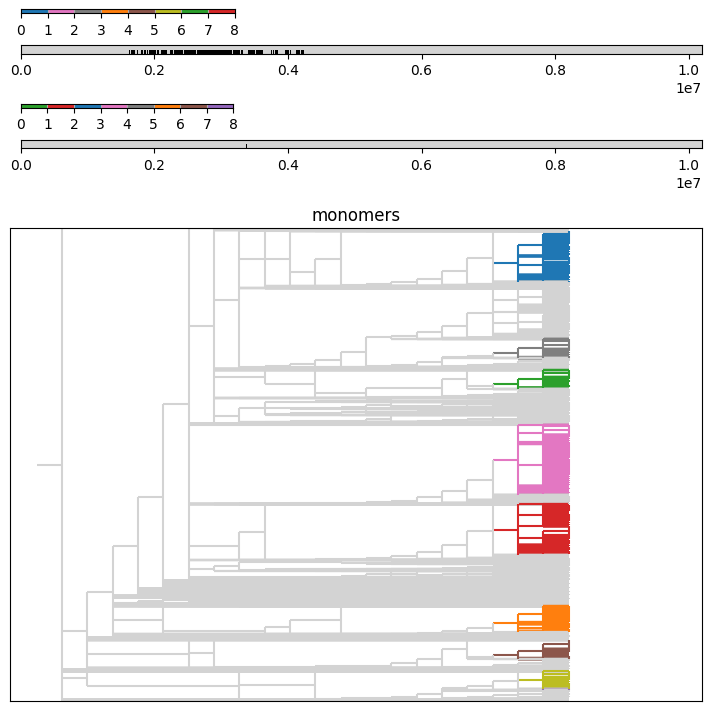

Subtree: [1, 2, 5, 1, 1, 1, 1, 1, 1, 2, 1]


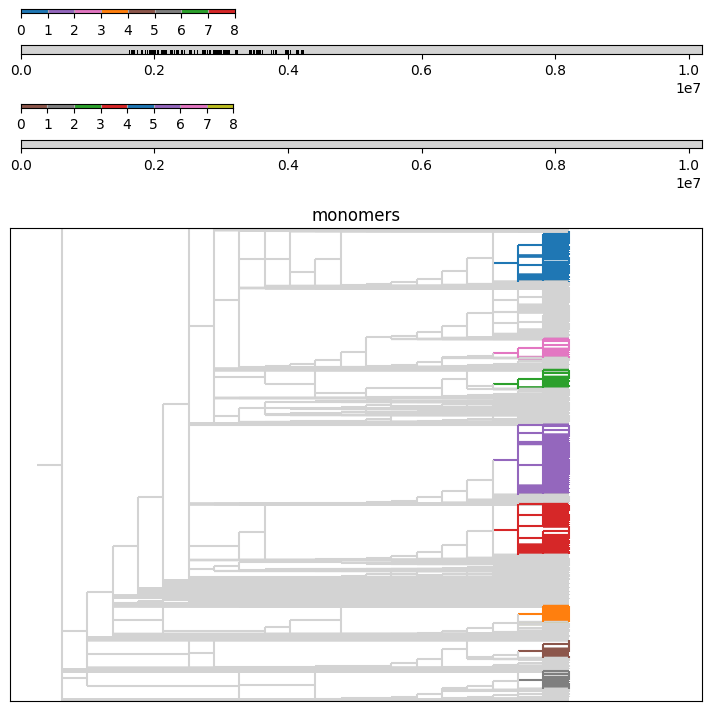

Subtree: [1, 2, 5, 1, 1, 1, 1, 1, 1, 2, 1, 1]


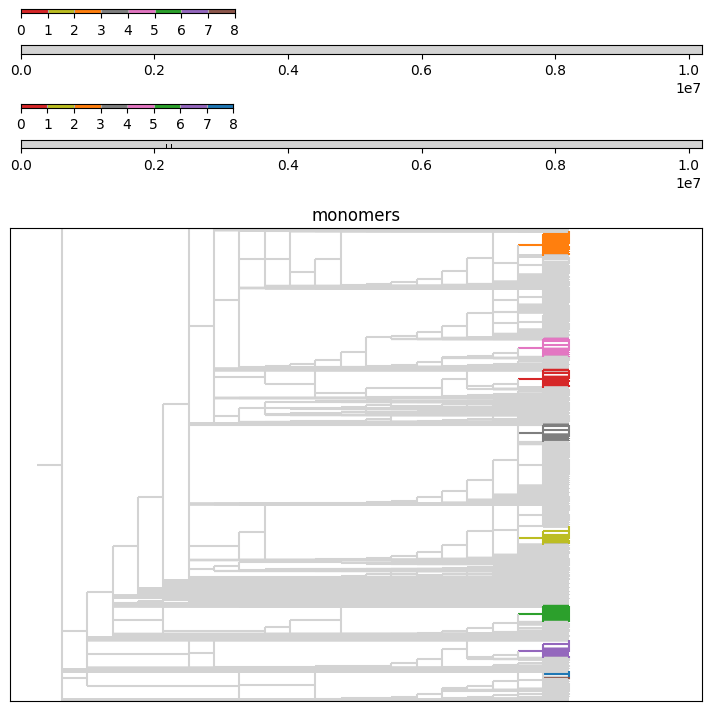

Subtree: [1, 2, 5, 2]


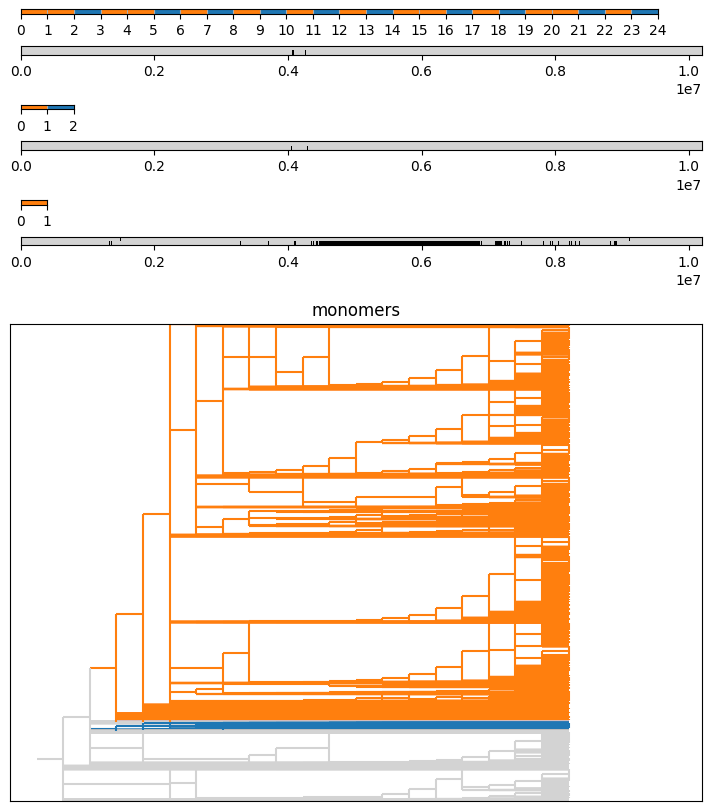

Subtree: [1, 2, 5, 2, 1]


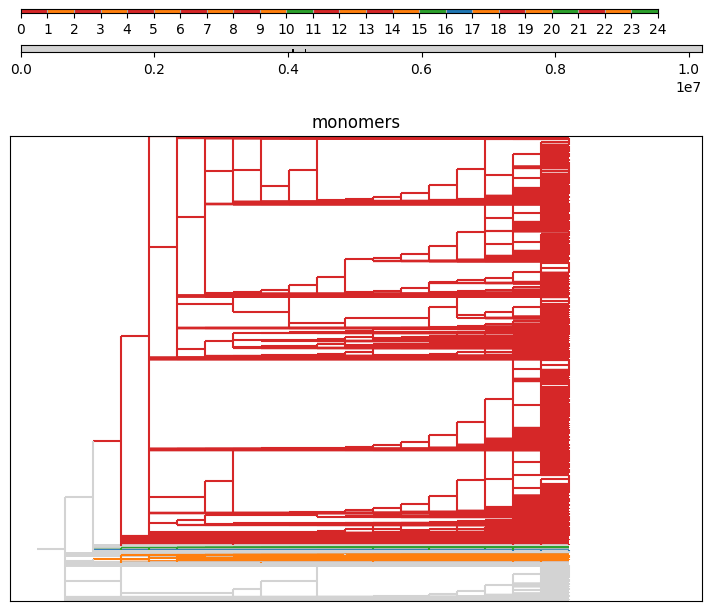

Subtree: [1, 2, 5, 2, 1, 1]


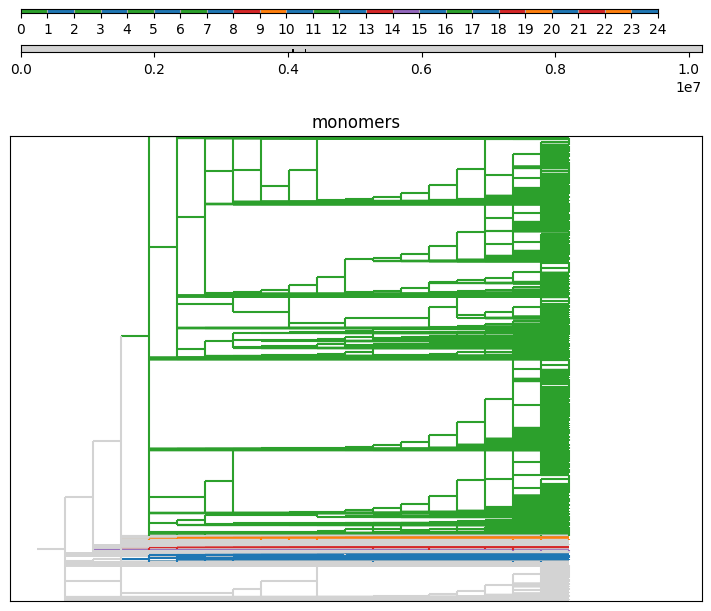

Subtree: [1, 2, 5, 2, 1, 1, 1]


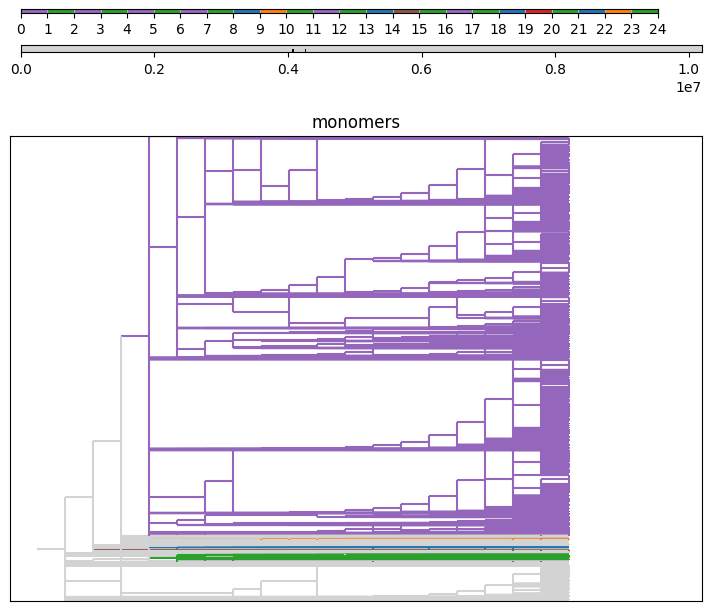

Subtree: [1, 2, 5, 2, 1, 1, 1, 1]


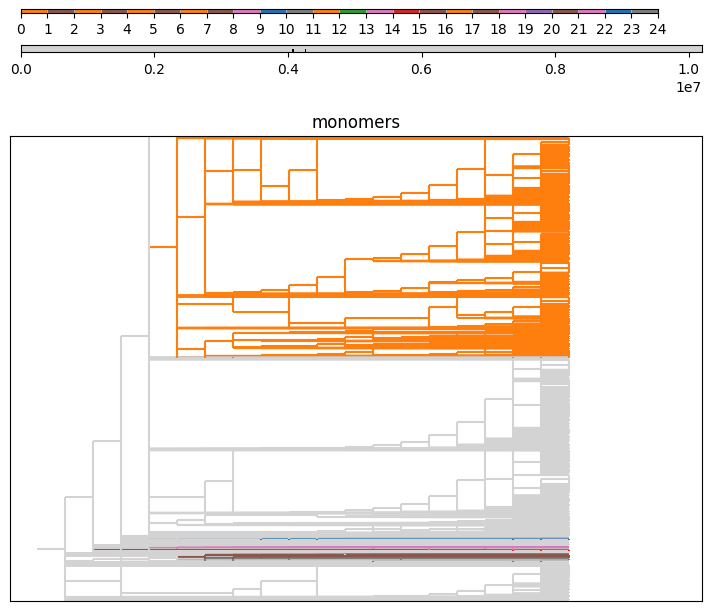

Subtree: [1, 2, 5, 2, 1, 1, 1, 1, 1]


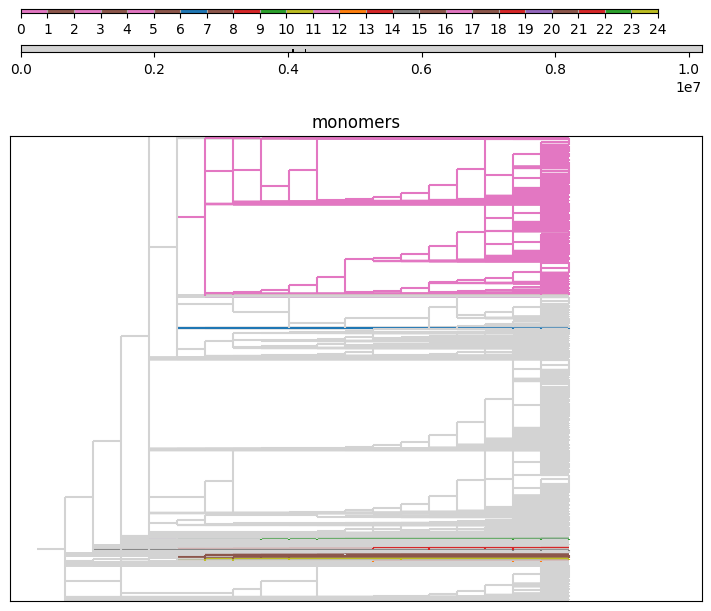

Subtree: [1, 2, 5, 2, 1, 1, 1, 1, 1, 1]


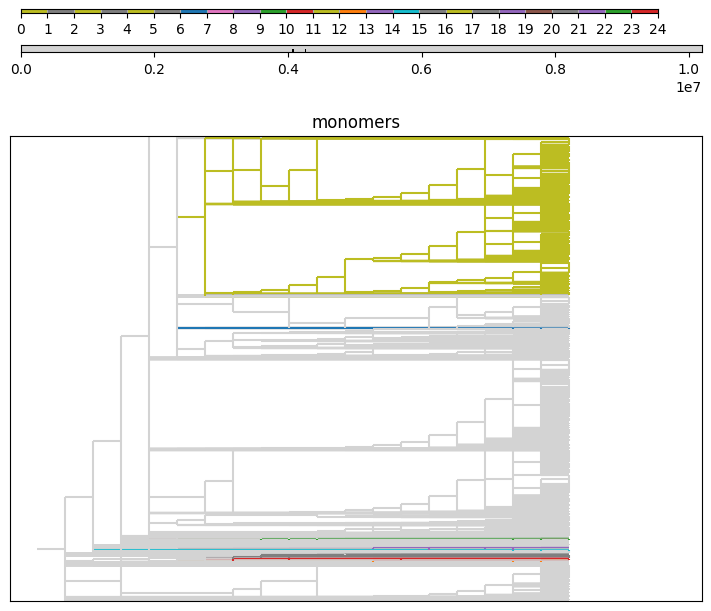

Subtree: [1, 2, 5, 2, 1, 1, 1, 1, 1, 1, 1]


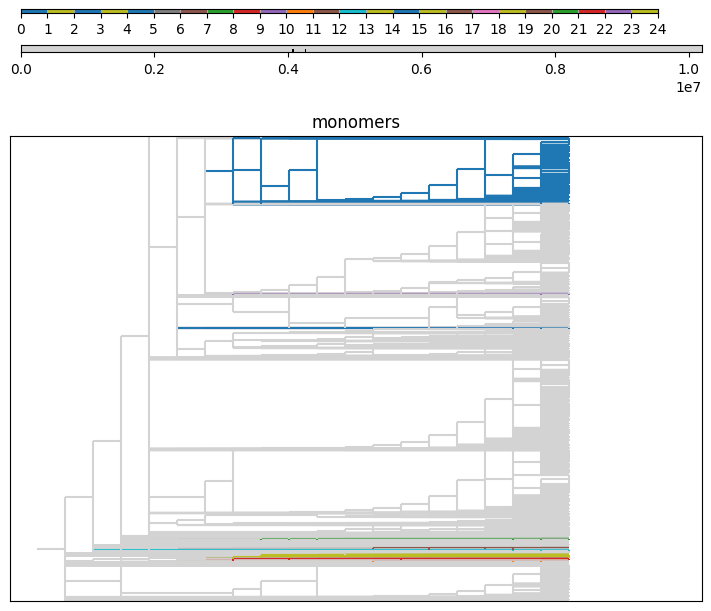

Subtree: [1, 2, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1]


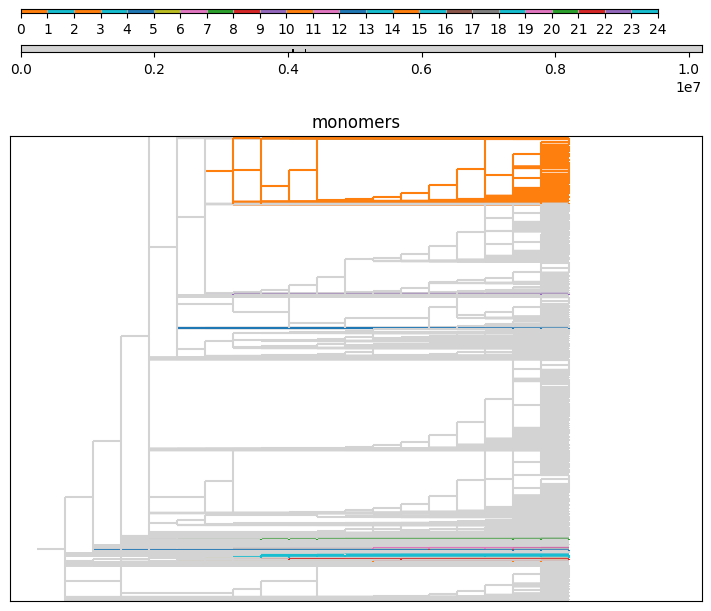

Subtree: [1, 2, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]


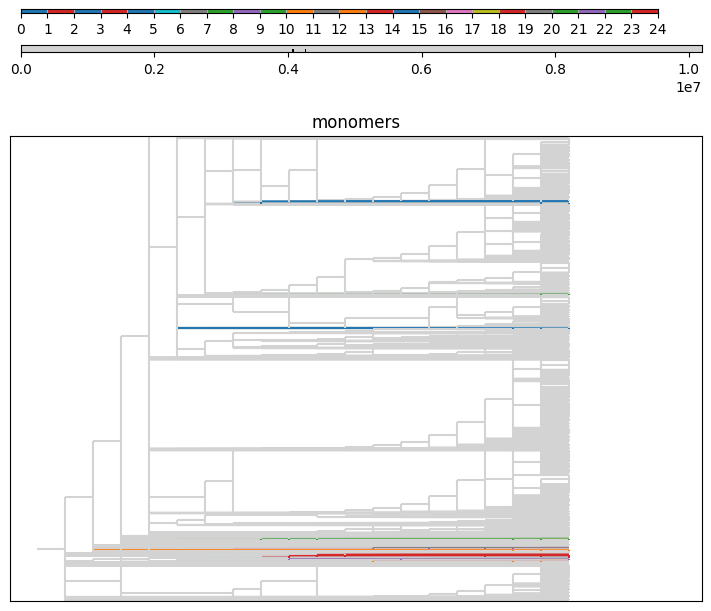

Subtree: [1, 2, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


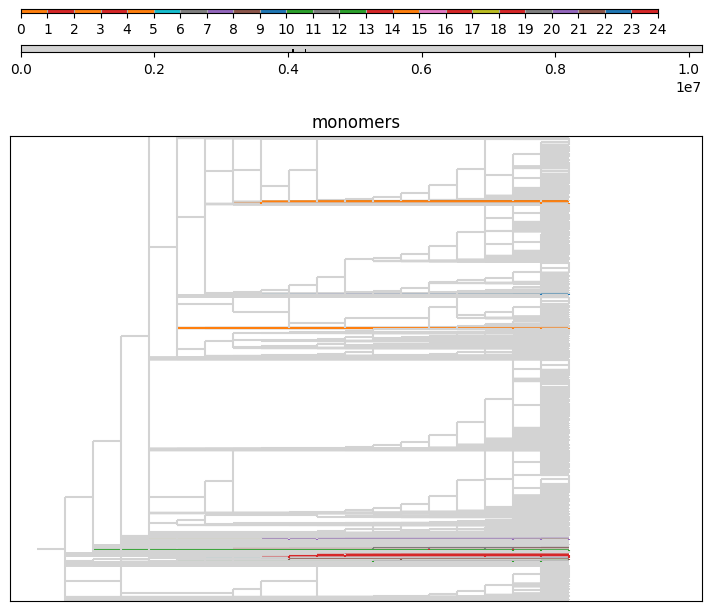

Subtree: [1, 2, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


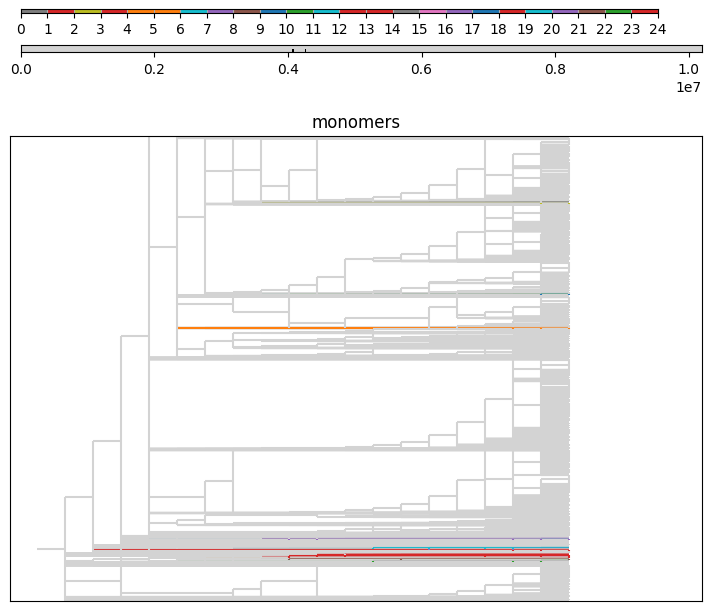

Subtree: [1, 2, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


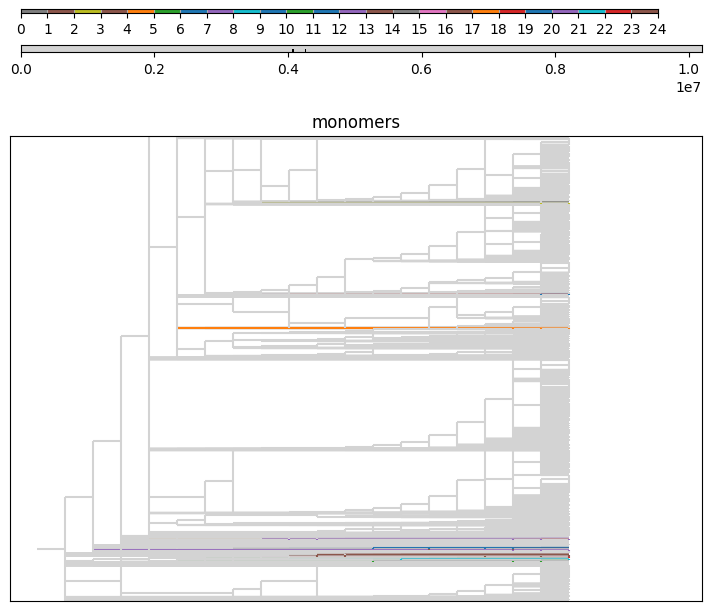

Subtree: [1, 2, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


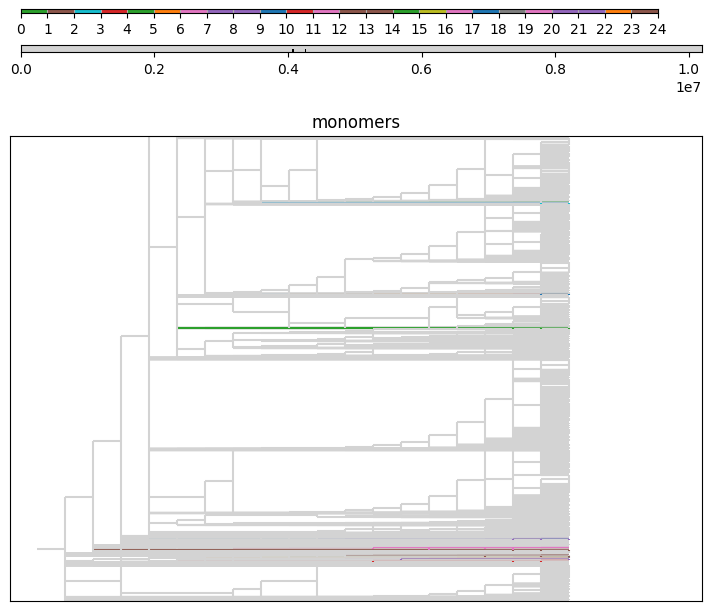

Subtree: [1, 2, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


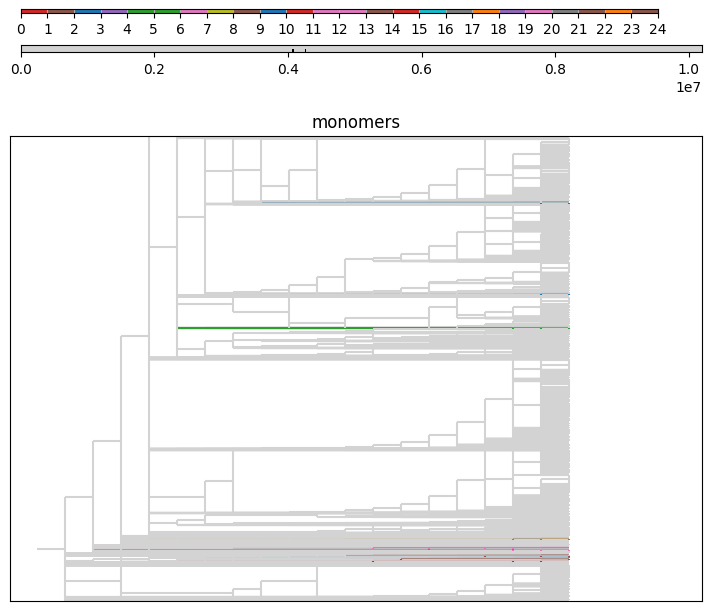

Subtree: [1, 2, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


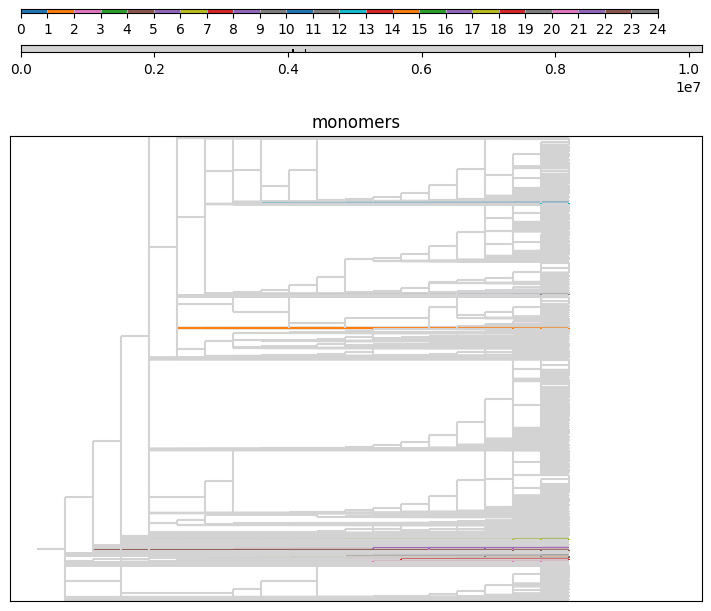

Subtree: [1, 2, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


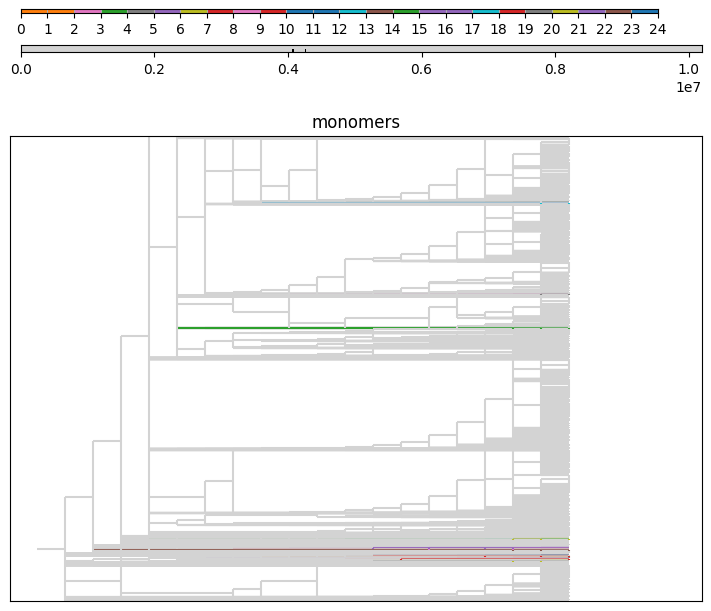

Subtree: [1, 2, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


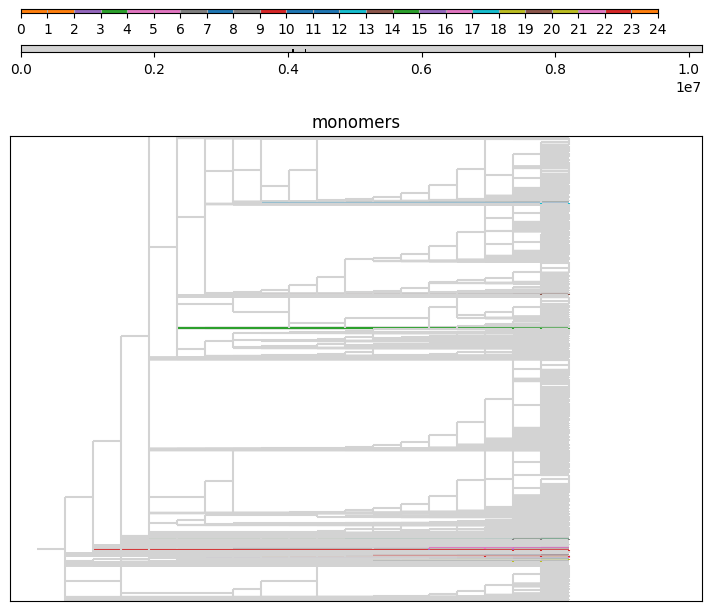

Subtree: [1, 2, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


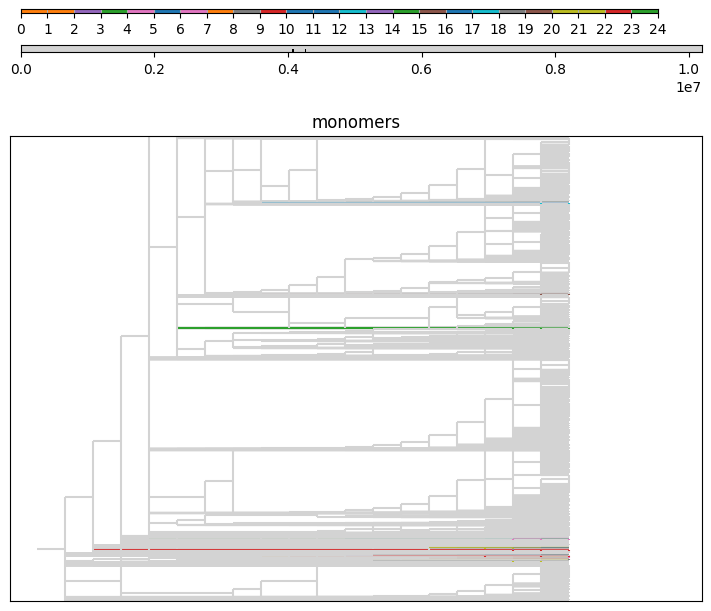

Subtree: [1, 2, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


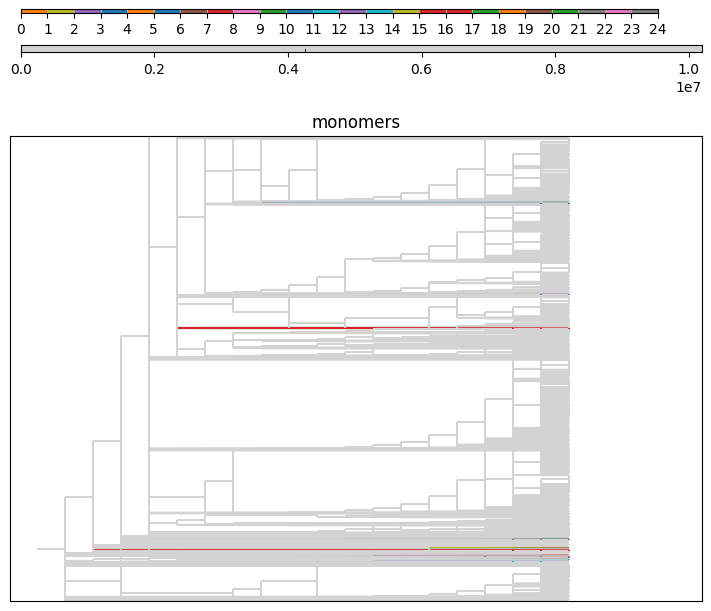

Subtree: [1, 2, 5, 2, 3]


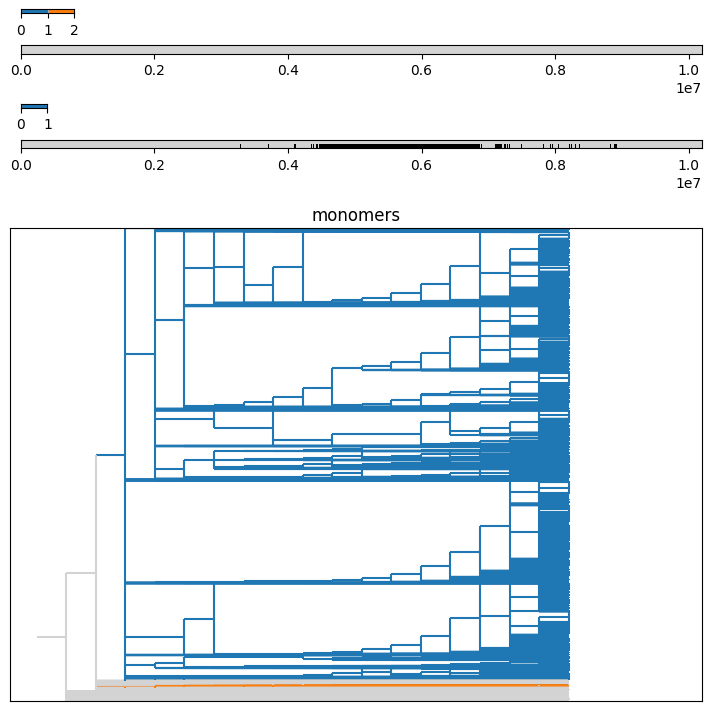

Subtree: [1, 2, 5, 2, 3, 2]


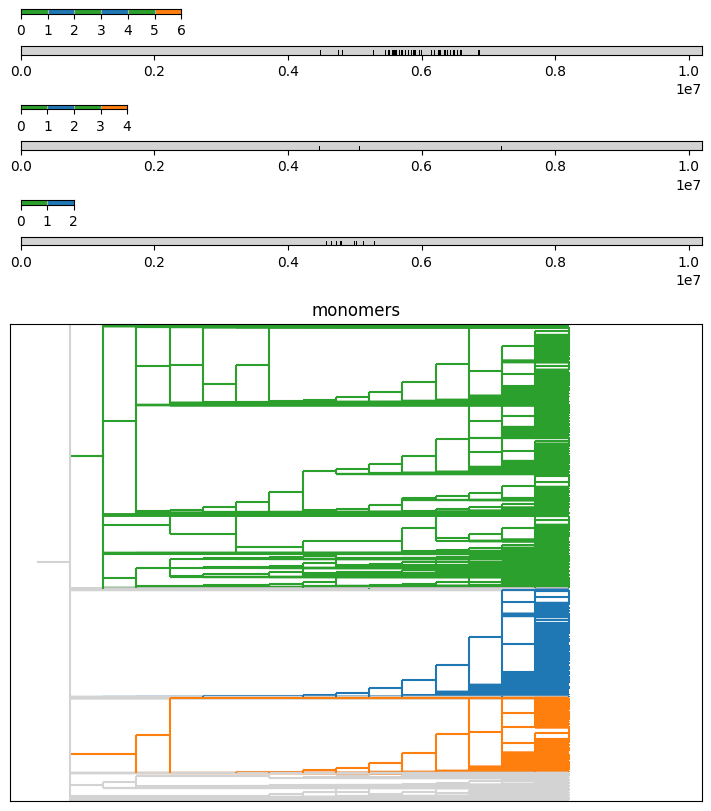

Subtree: [1, 2, 5, 2, 3, 2, 1]


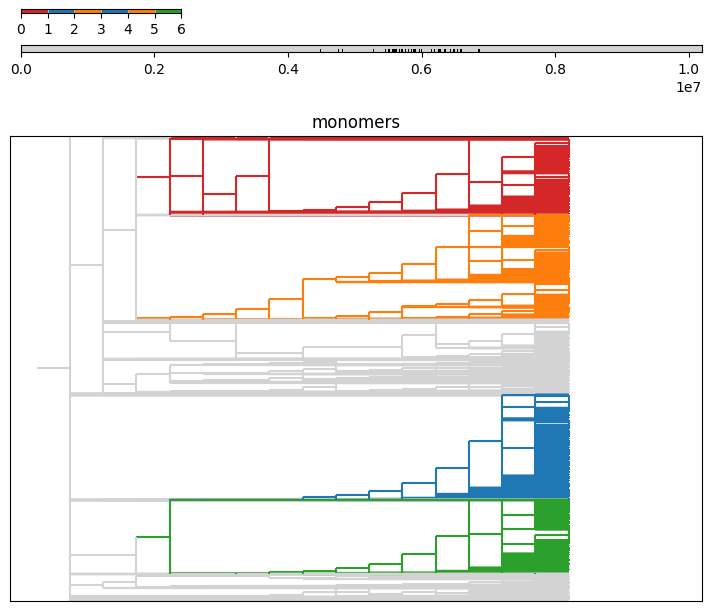

Subtree: [1, 2, 5, 2, 3, 2, 1, 1]


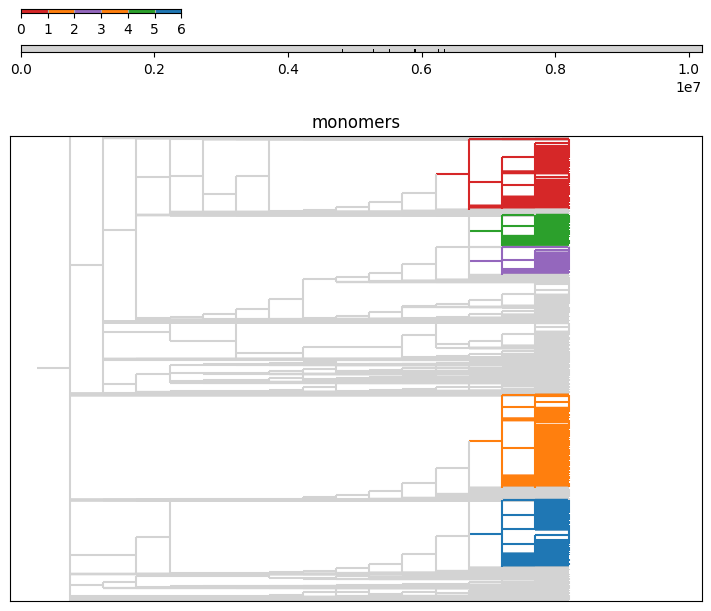

Subtree: [1, 2, 5, 2, 3, 2, 2]


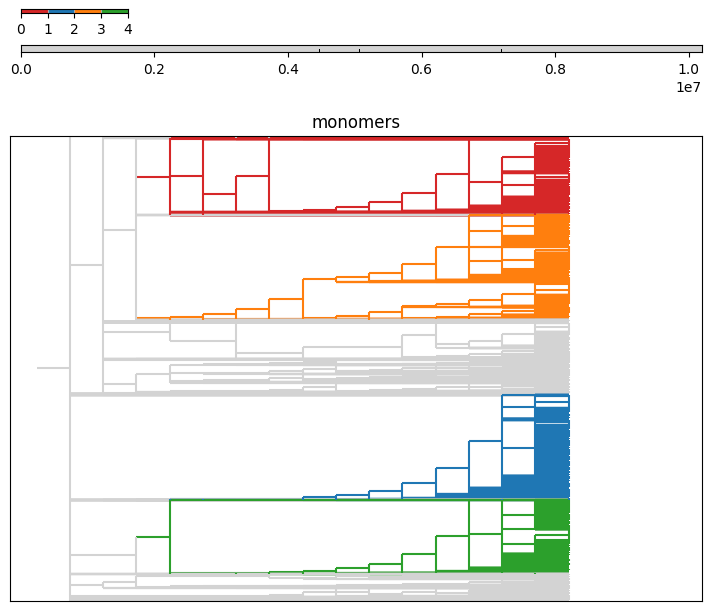

In [22]:
show_hor_tree(hor_tree_root=hor_tree.as_hor_in_seq, reference_seq=references[reference_seq_id], tree=phylogeny)

Subtree: []


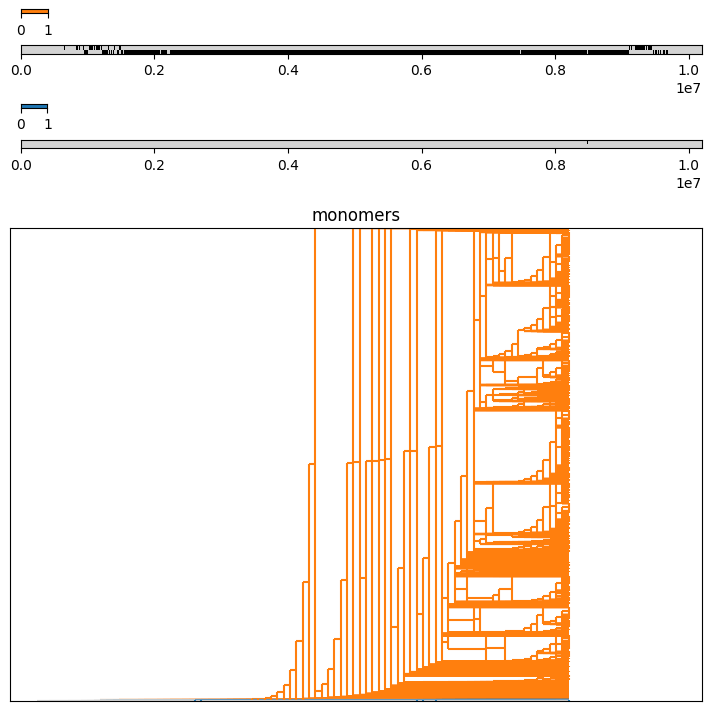

Subtree: [1]


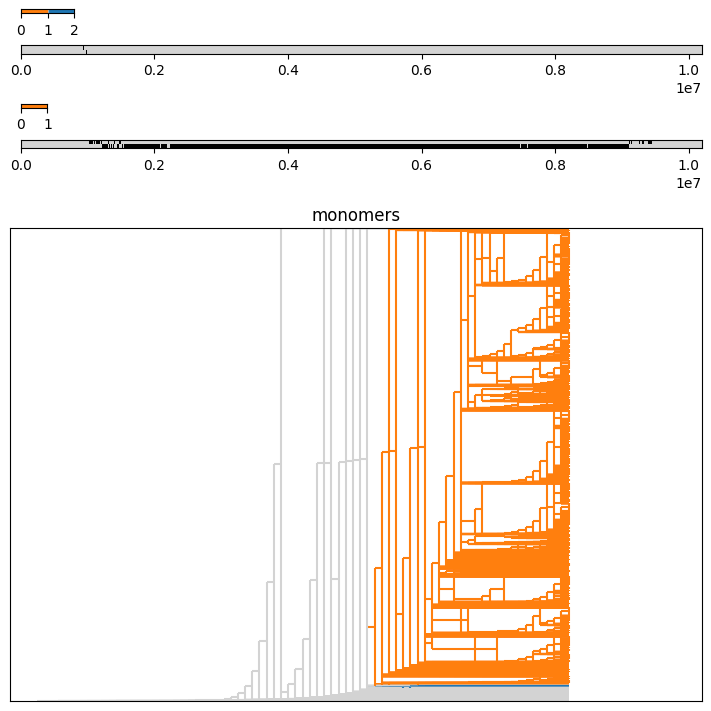

Subtree: [1, 2]


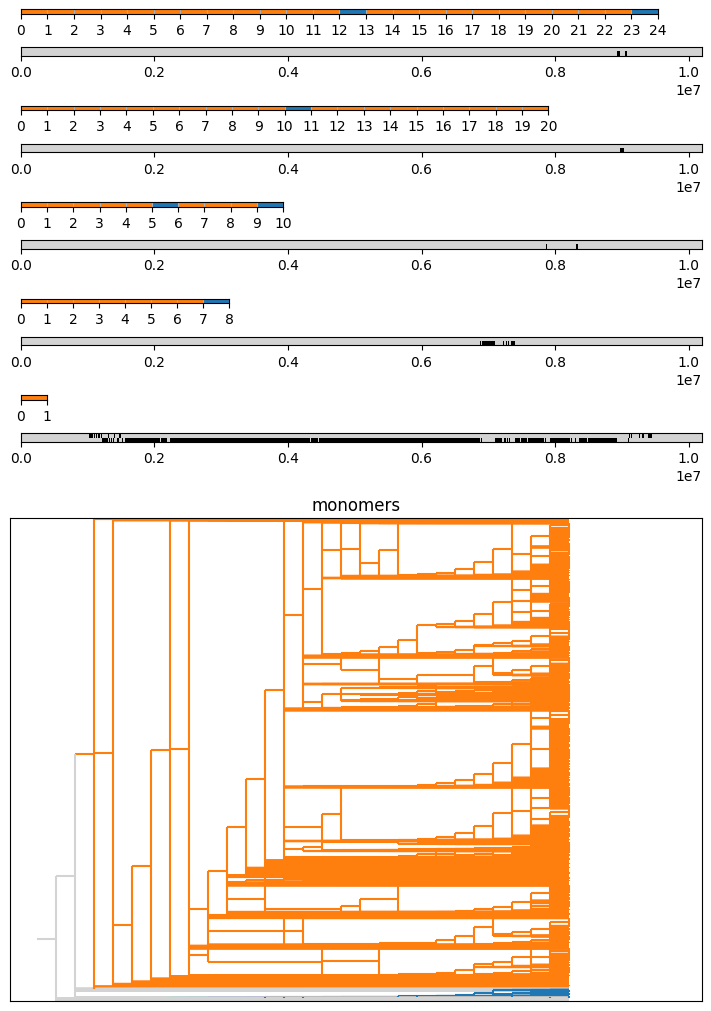

Subtree: [1, 2, 1]


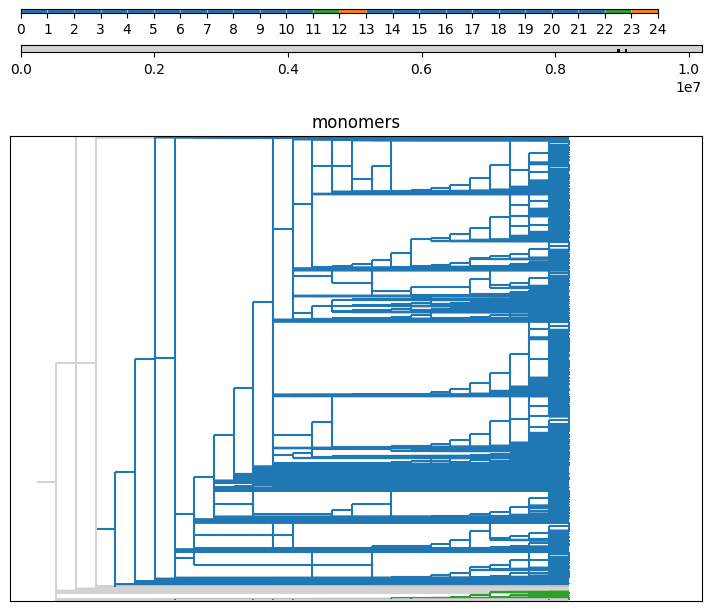

Subtree: [1, 2, 1, 1]


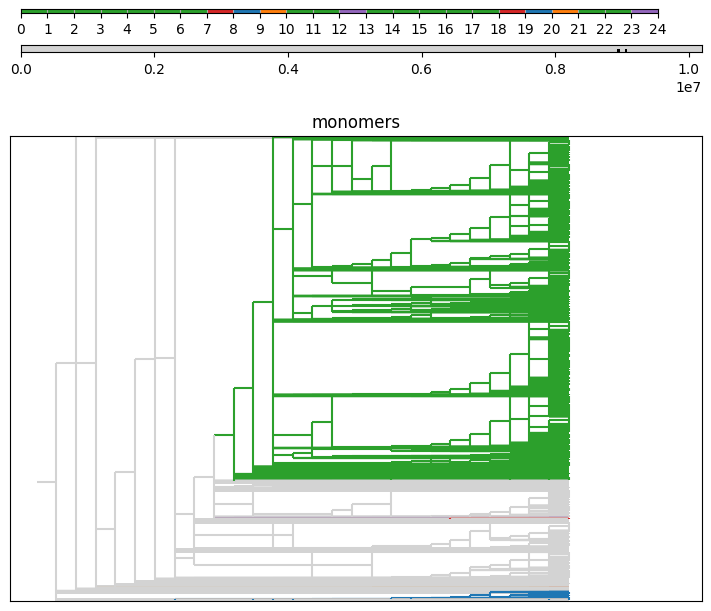

Subtree: [1, 2, 1, 1, 1]


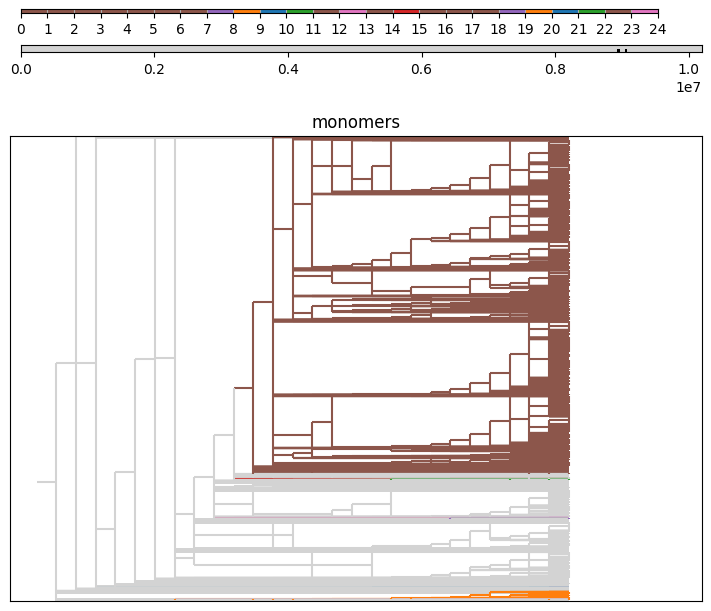

Subtree: [1, 2, 1, 1, 1, 1]


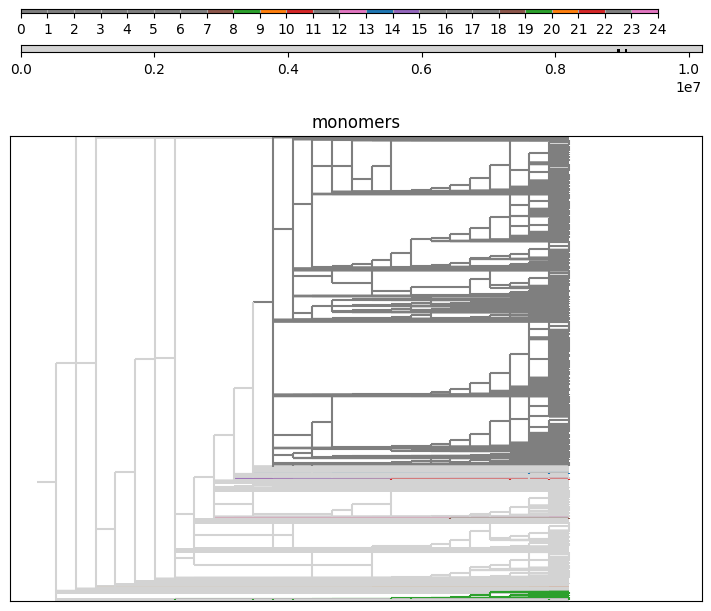

Subtree: [1, 2, 1, 1, 1, 1, 1]


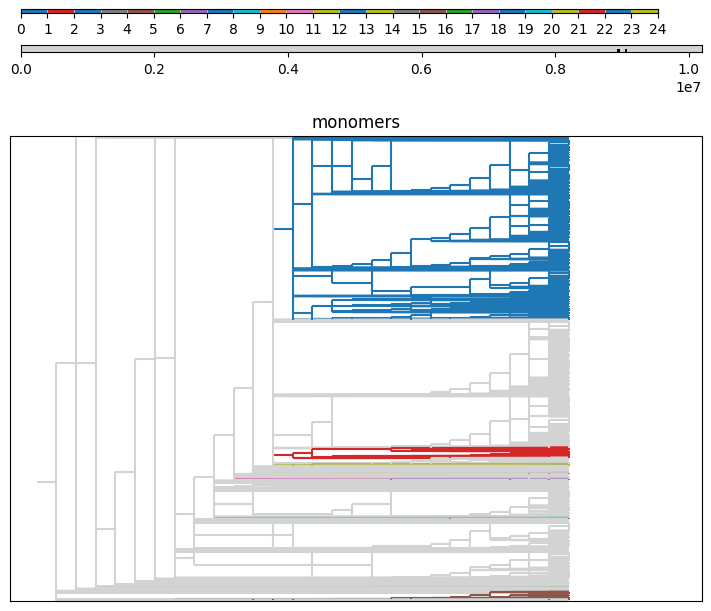

Subtree: [1, 2, 1, 1, 1, 1, 1, 1]


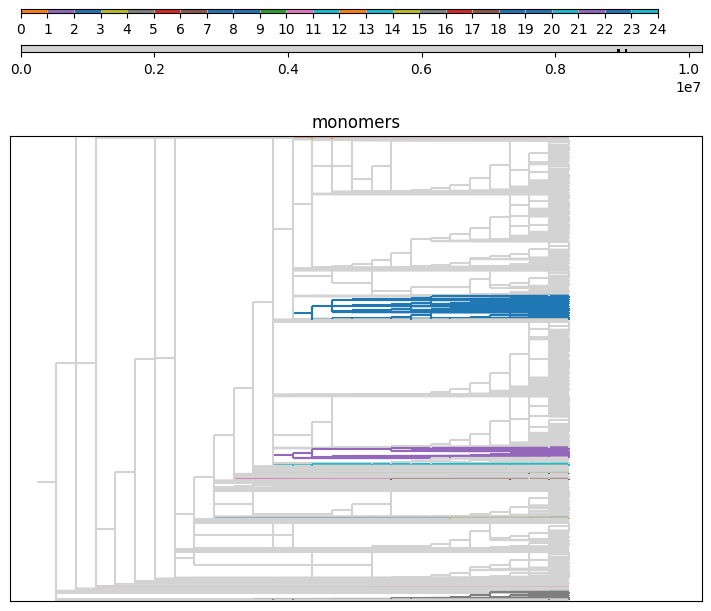

Subtree: [1, 2, 1, 1, 1, 1, 1, 1, 1]


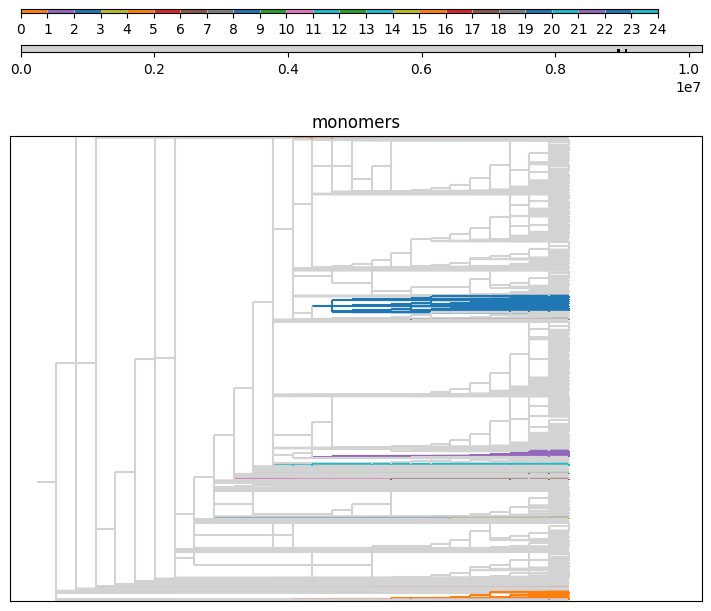

Subtree: [1, 2, 1, 1, 1, 1, 1, 1, 1, 1]


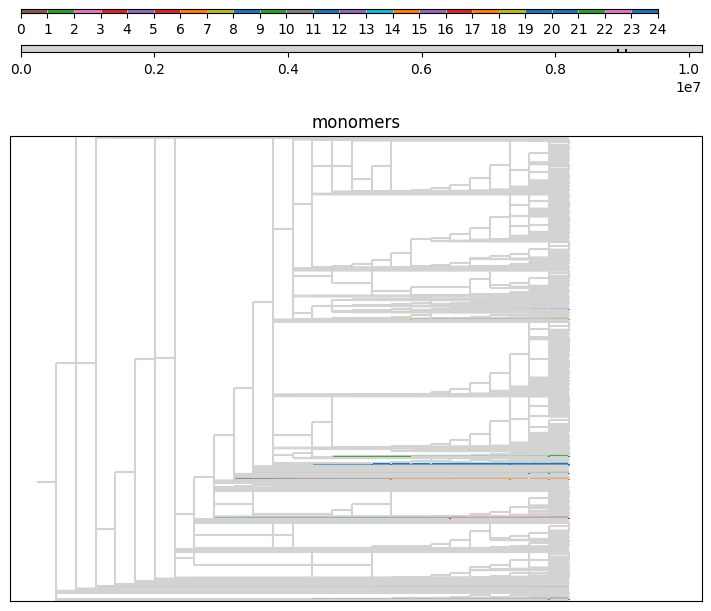

Subtree: [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]


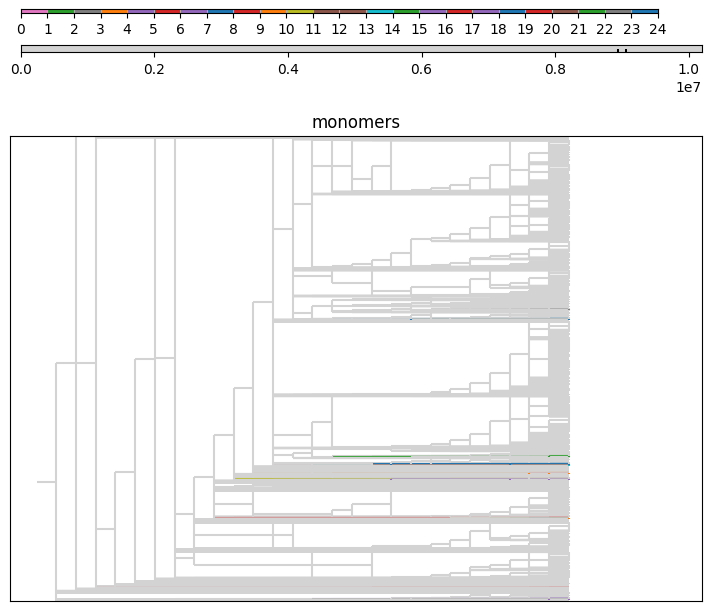

Subtree: [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


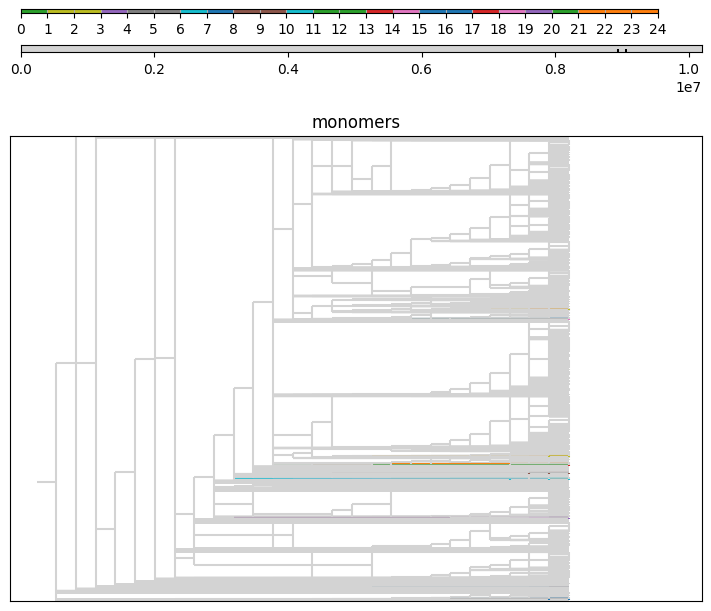

Subtree: [1, 2, 2]


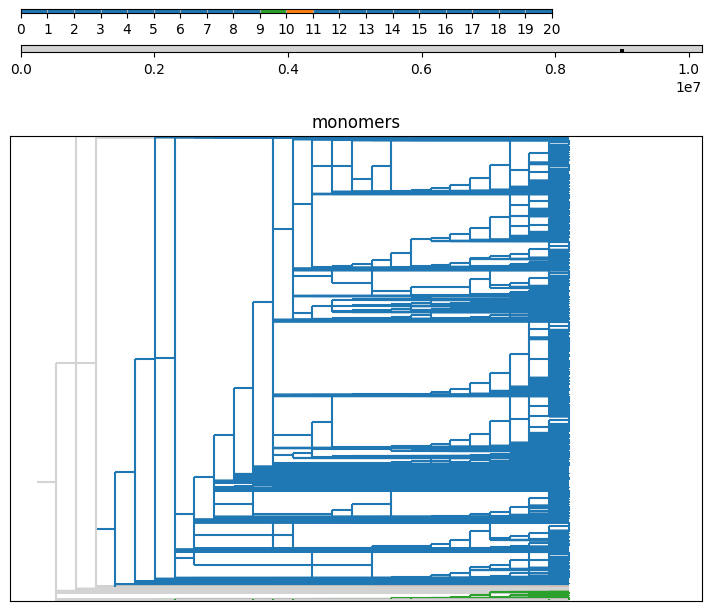

Subtree: [1, 2, 2, 1]


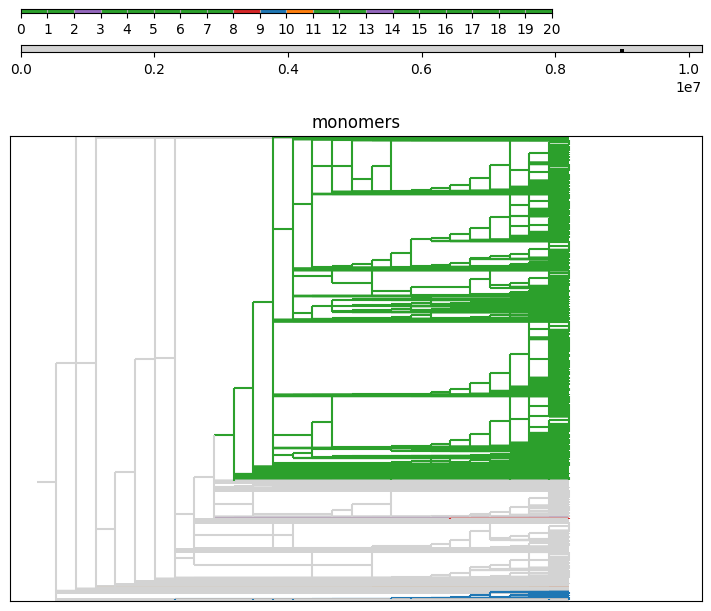

Subtree: [1, 2, 2, 1, 1]


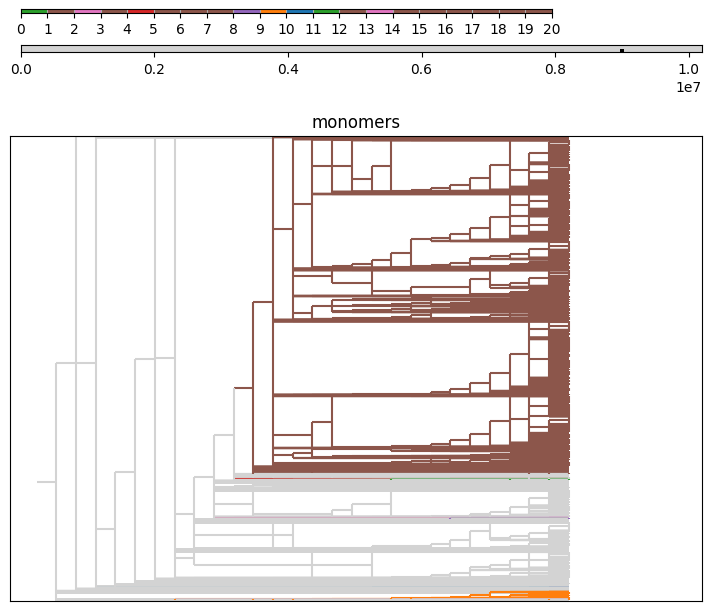

Subtree: [1, 2, 2, 1, 1, 1]


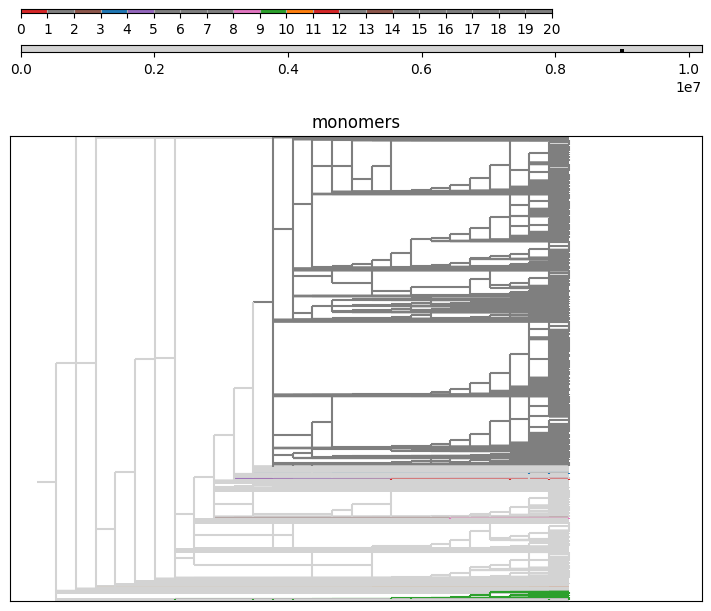

Subtree: [1, 2, 2, 1, 1, 1, 1]


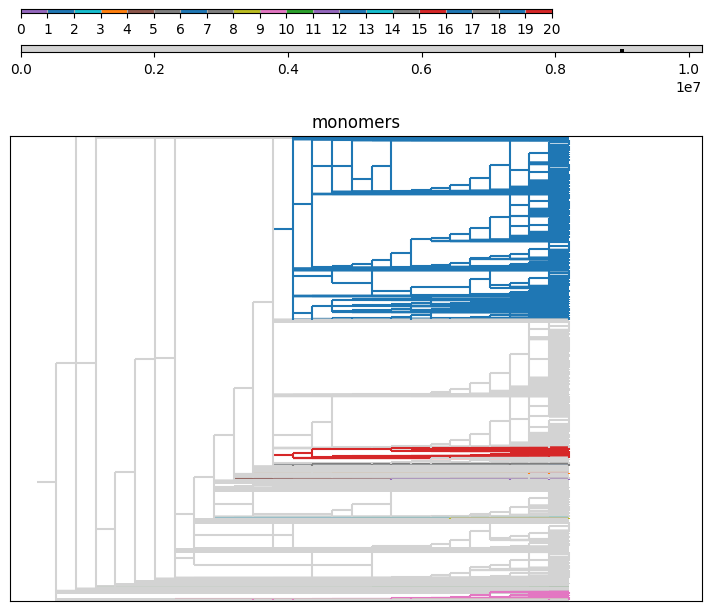

Subtree: [1, 2, 2, 1, 1, 1, 1, 1]


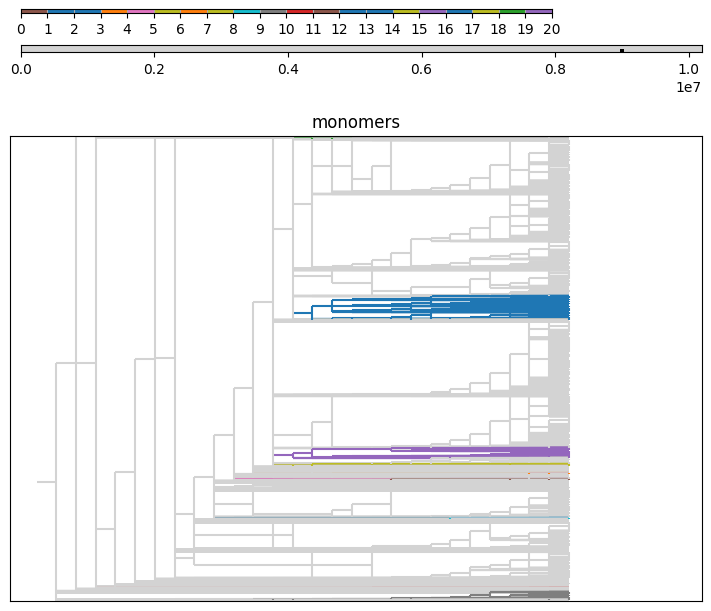

Subtree: [1, 2, 2, 1, 1, 1, 1, 1, 1]


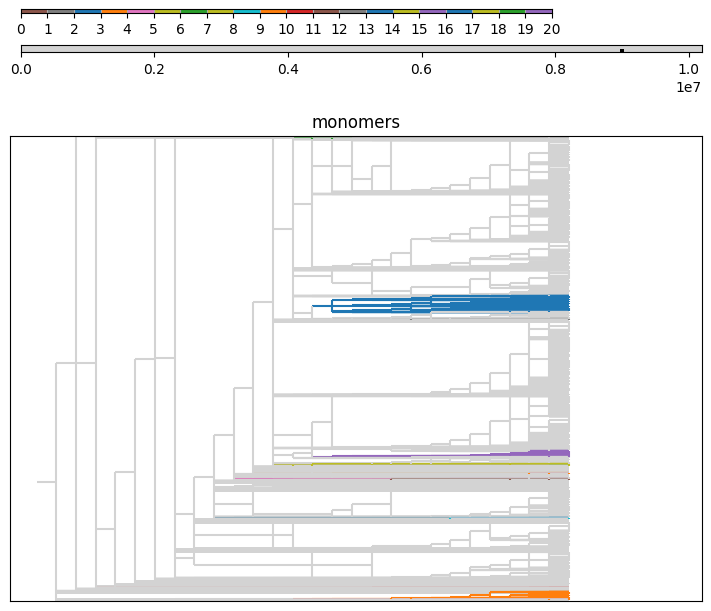

Subtree: [1, 2, 2, 1, 1, 1, 1, 1, 1, 1]


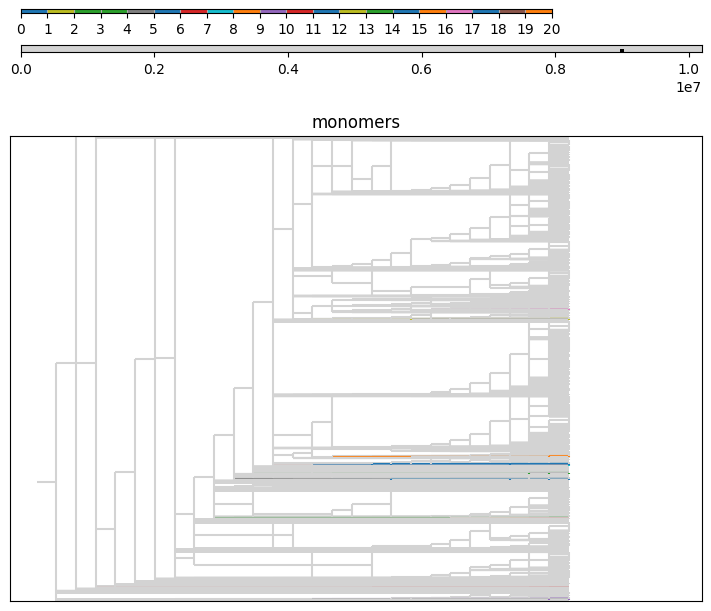

Subtree: [1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1]


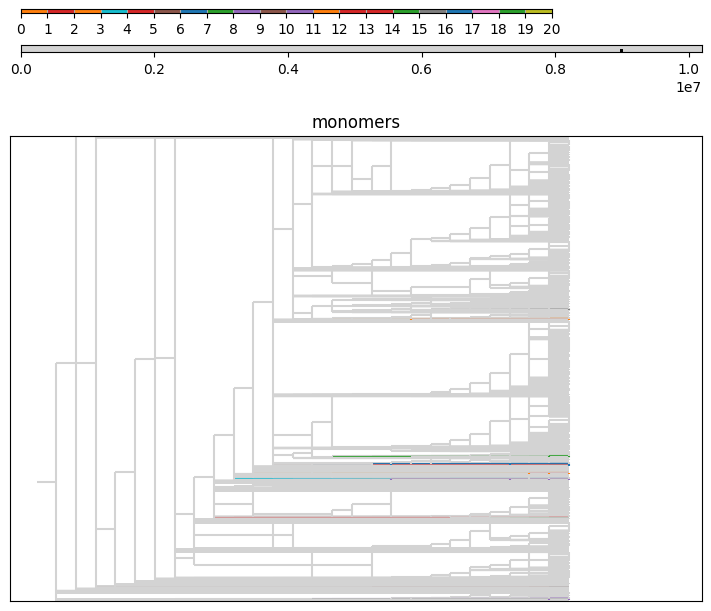

Subtree: [1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]


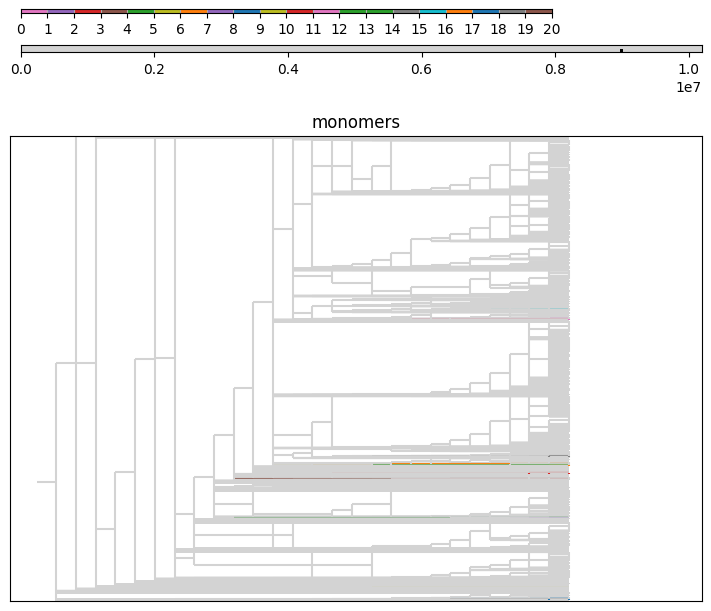

Subtree: [1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


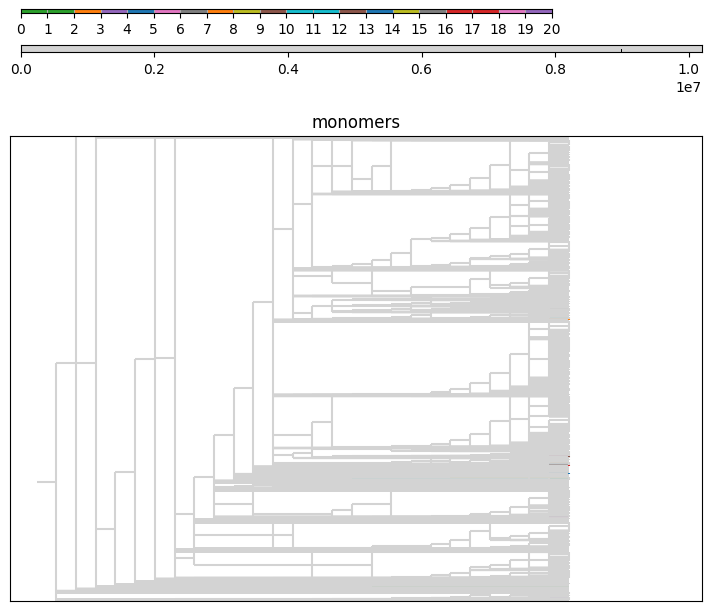

Subtree: [1, 2, 3]


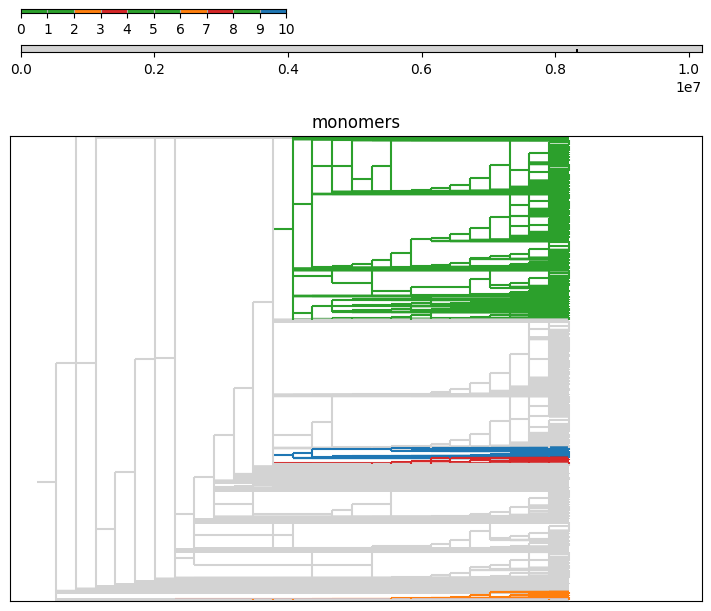

Subtree: [1, 2, 3, 1]


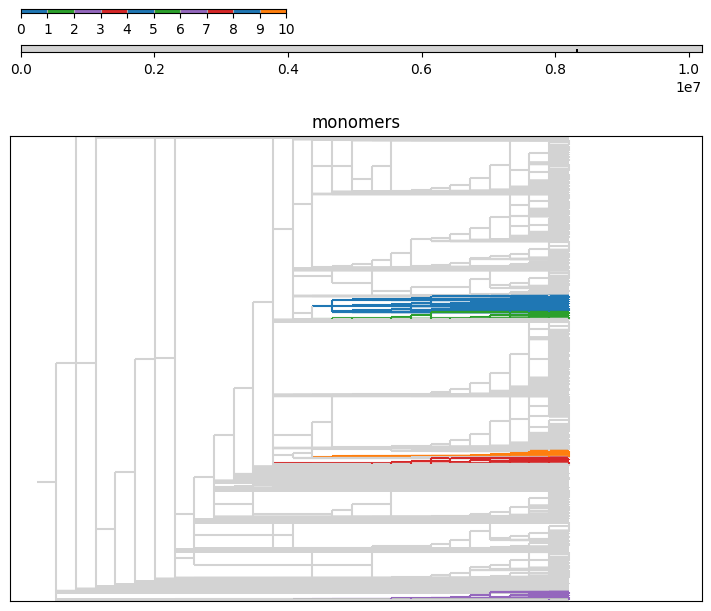

Subtree: [1, 2, 3, 1, 1]


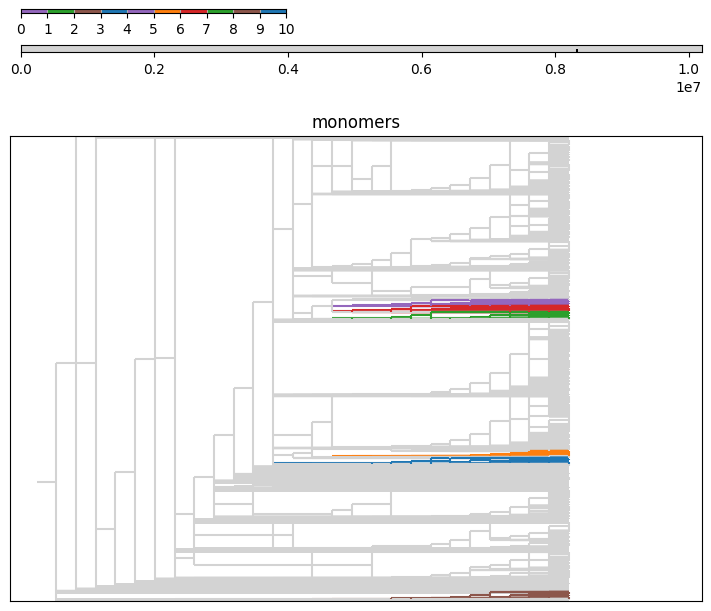

Subtree: [1, 2, 3, 1, 1, 1]


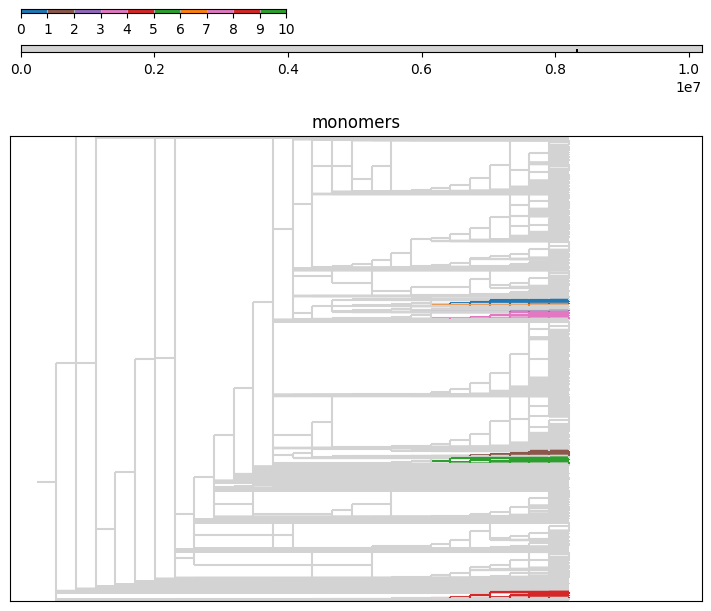

Subtree: [1, 2, 3, 1, 1, 1, 1]


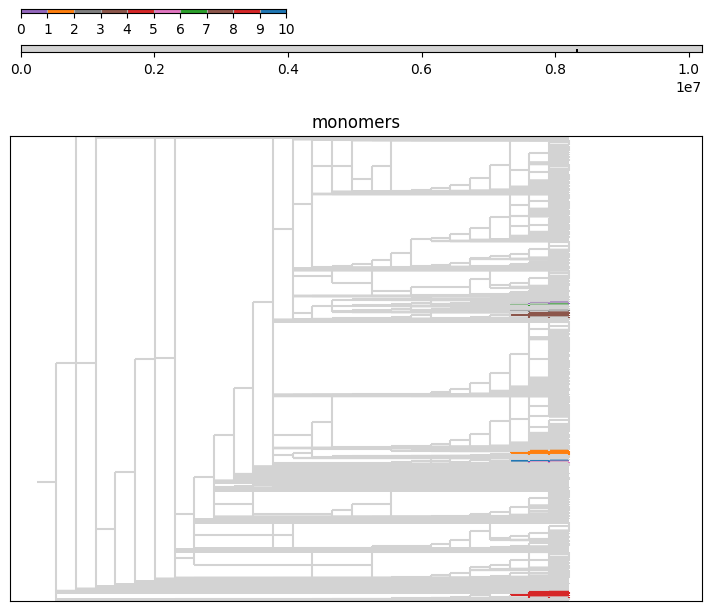

Subtree: [1, 2, 4]


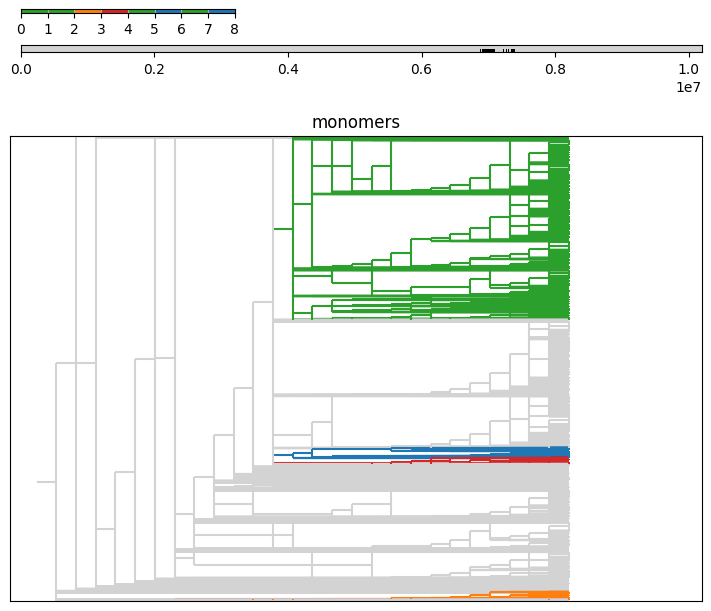

Subtree: [1, 2, 4, 1]


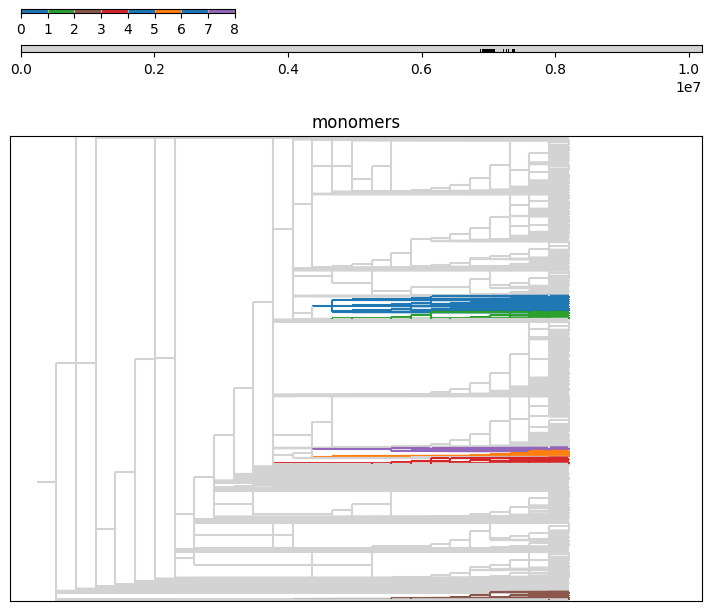

Subtree: [1, 2, 4, 1, 1]


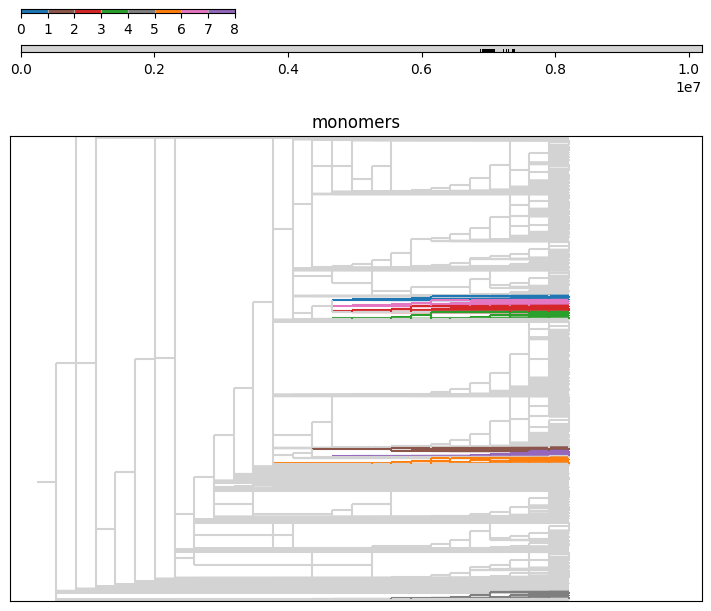

Subtree: [1, 2, 4, 1, 1, 1]


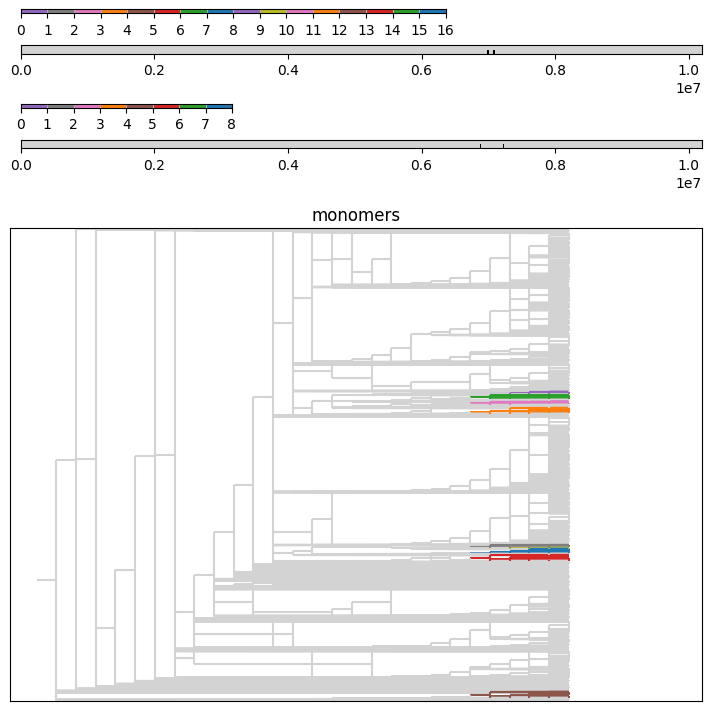

Subtree: [1, 2, 5]


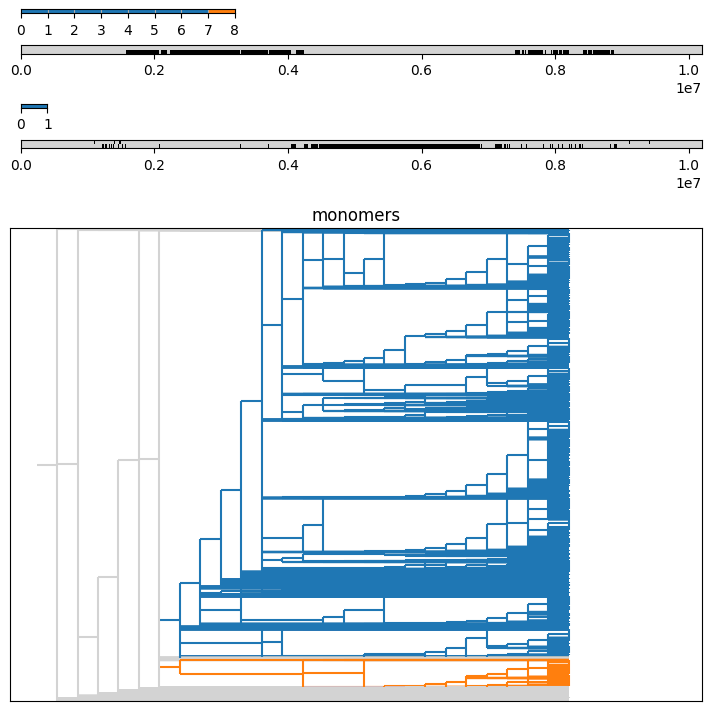

Subtree: [1, 2, 5, 1]


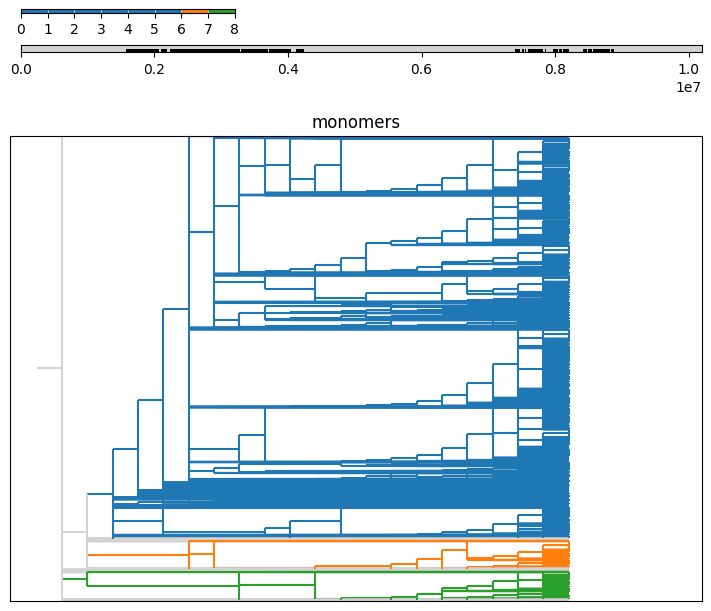

Subtree: [1, 2, 5, 1, 1]


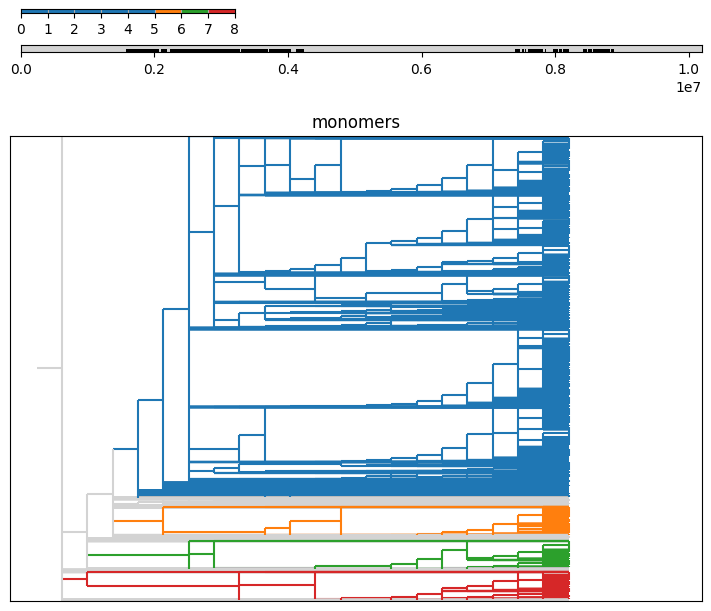

Subtree: [1, 2, 5, 1, 1, 1]


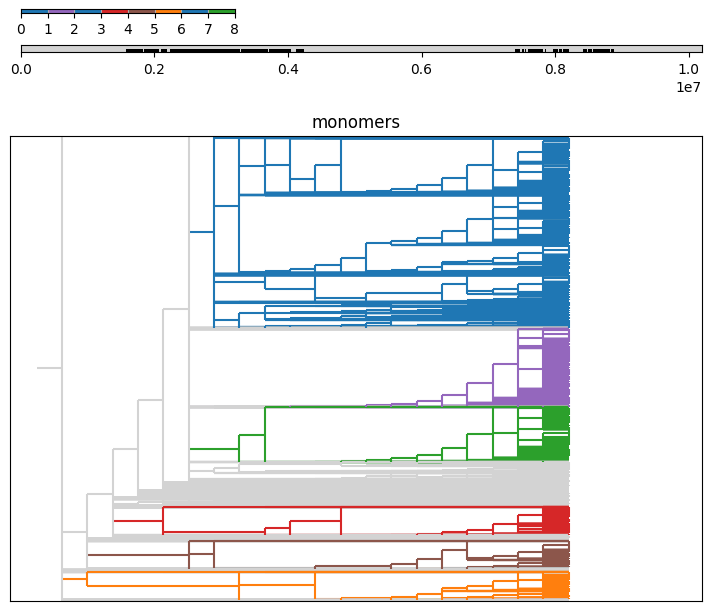

Subtree: [1, 2, 5, 1, 1, 1, 1]


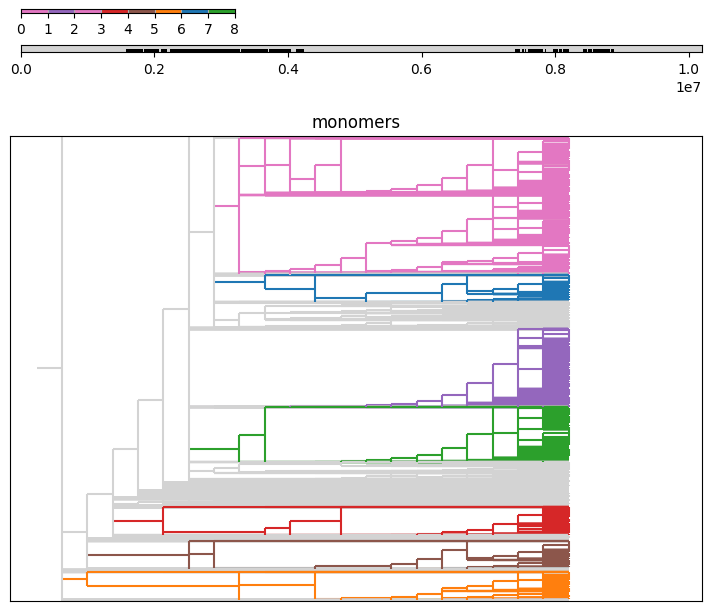

Subtree: [1, 2, 5, 1, 1, 1, 1, 1]


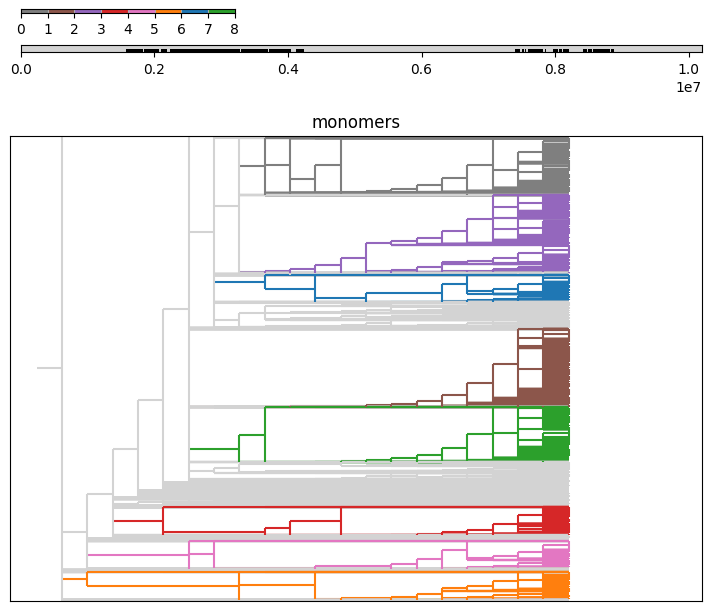

Subtree: [1, 2, 5, 1, 1, 1, 1, 1, 1]


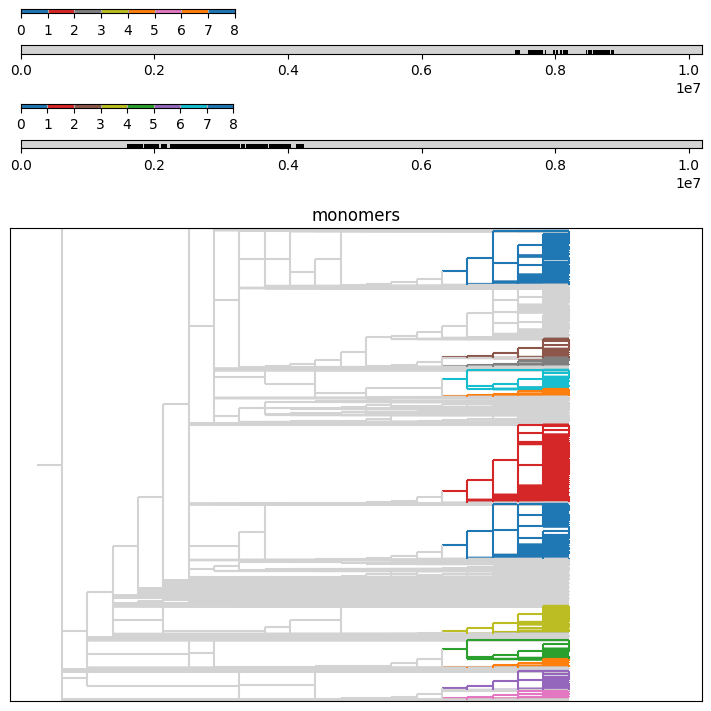

Subtree: [1, 2, 5, 1, 1, 1, 1, 1, 1, 2]


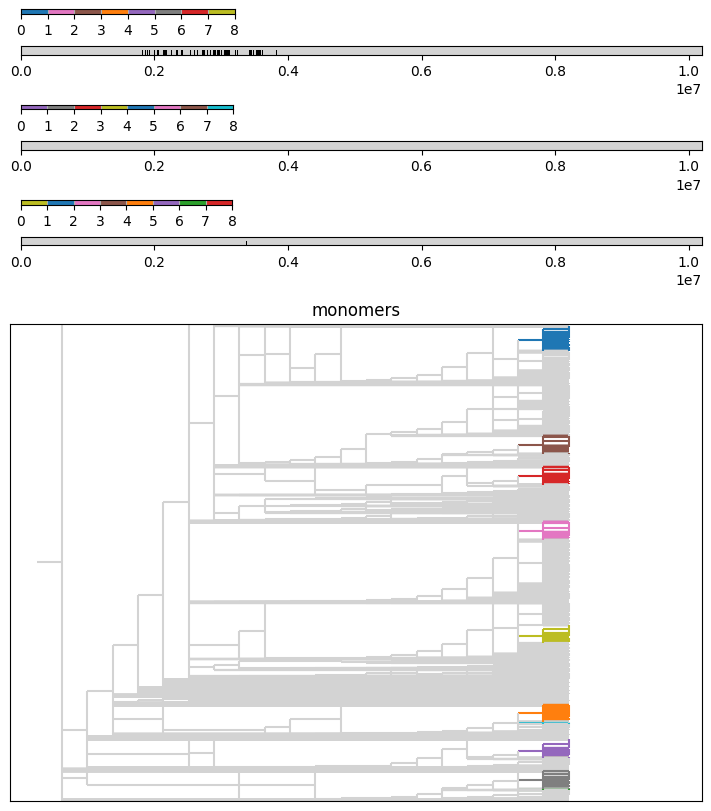

Subtree: [1, 2, 5, 2]


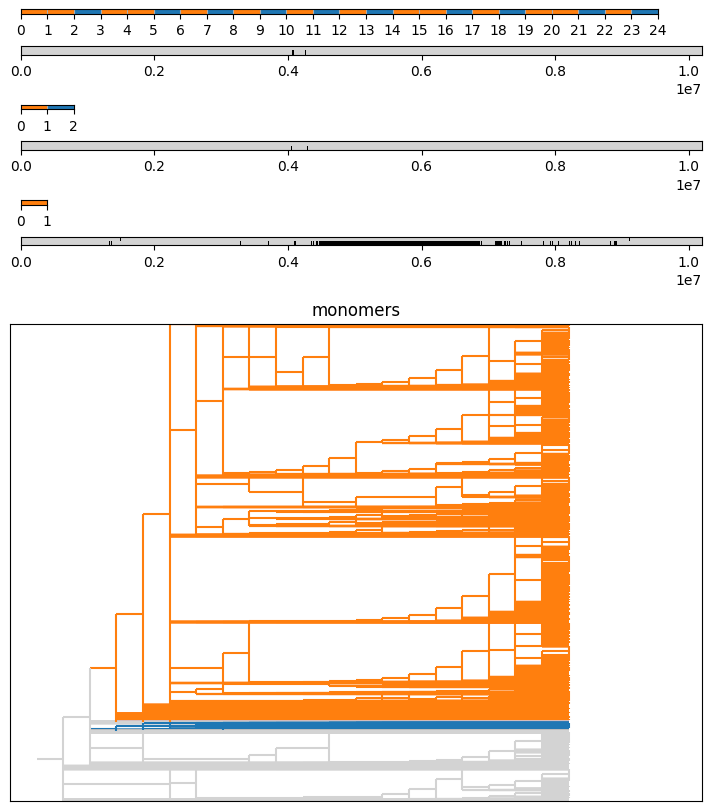

Subtree: [1, 2, 5, 2, 1]


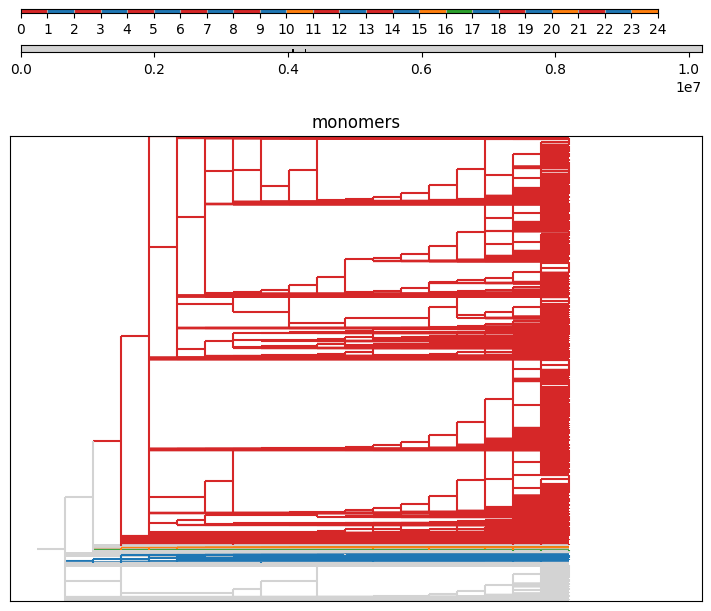

Subtree: [1, 2, 5, 2, 1, 1]


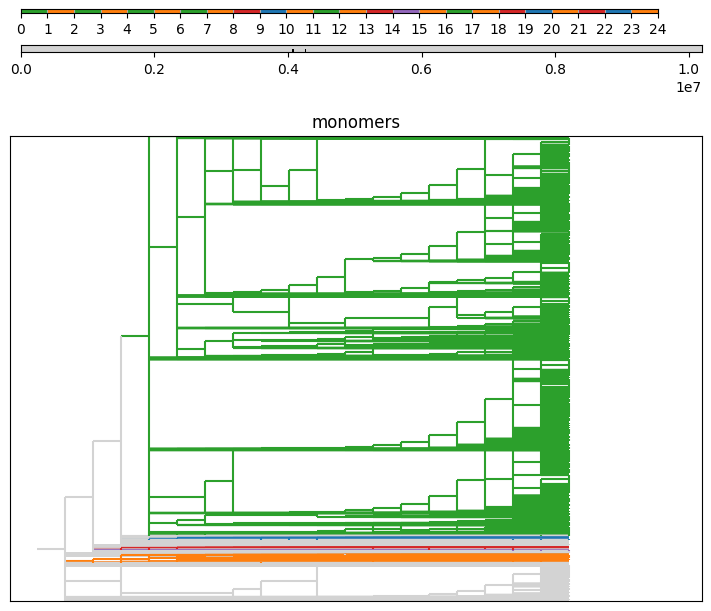

Subtree: [1, 2, 5, 2, 1, 1, 1]


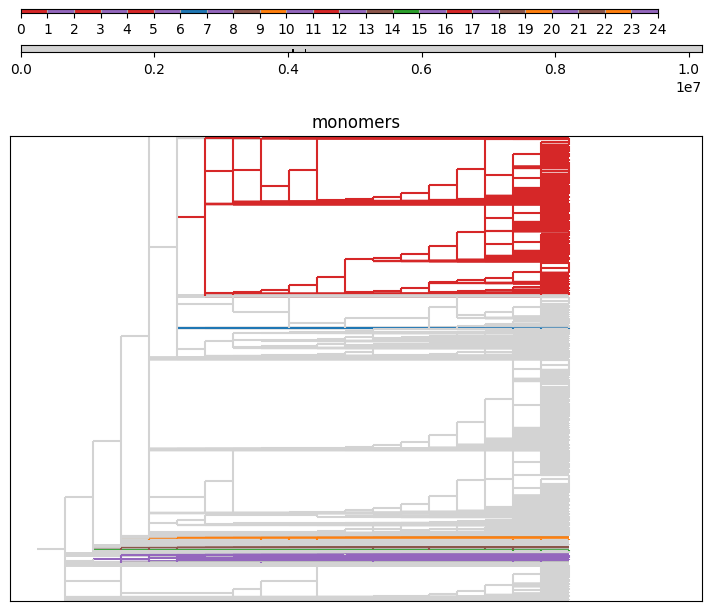

Subtree: [1, 2, 5, 2, 1, 1, 1, 1]


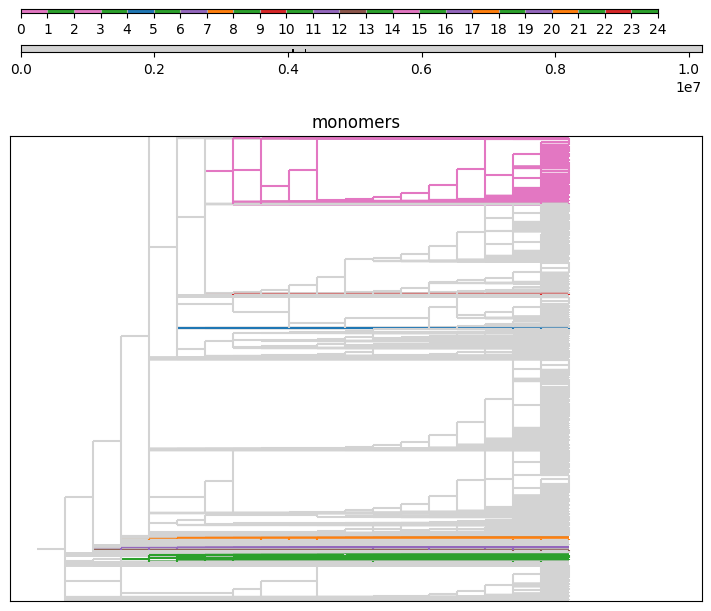

Subtree: [1, 2, 5, 2, 1, 1, 1, 1, 1]


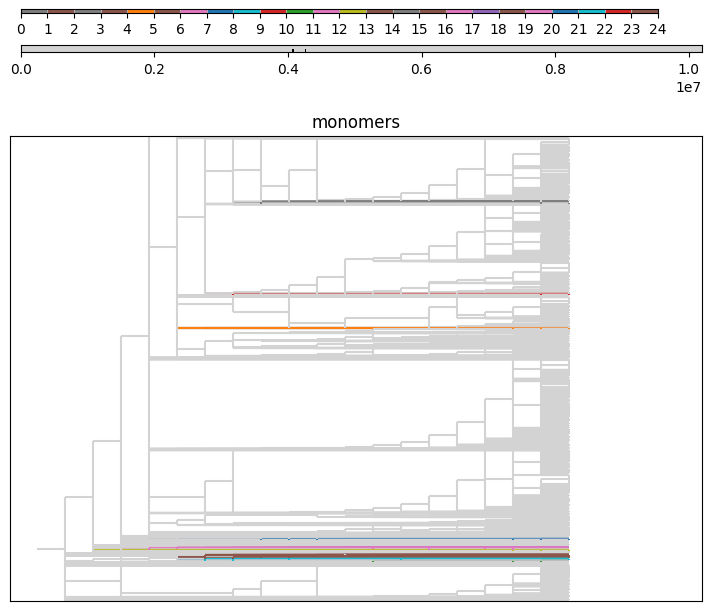

Subtree: [1, 2, 5, 2, 1, 1, 1, 1, 1, 1]


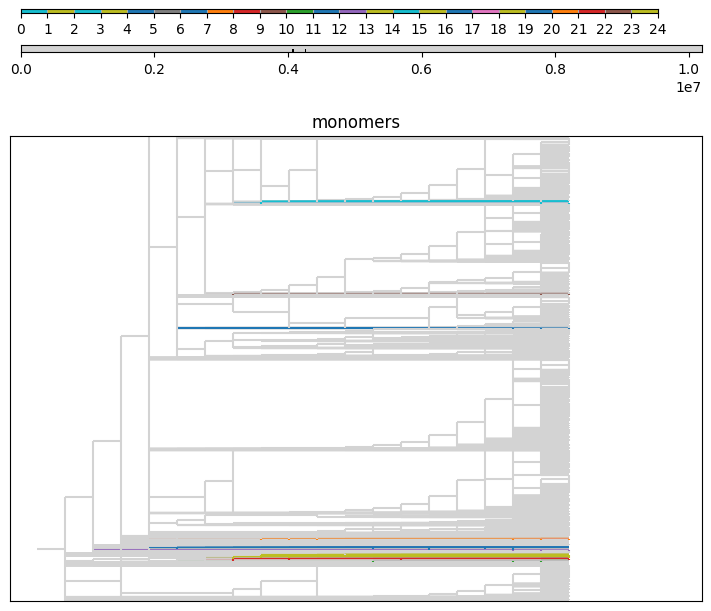

Subtree: [1, 2, 5, 2, 1, 1, 1, 1, 1, 1, 1]


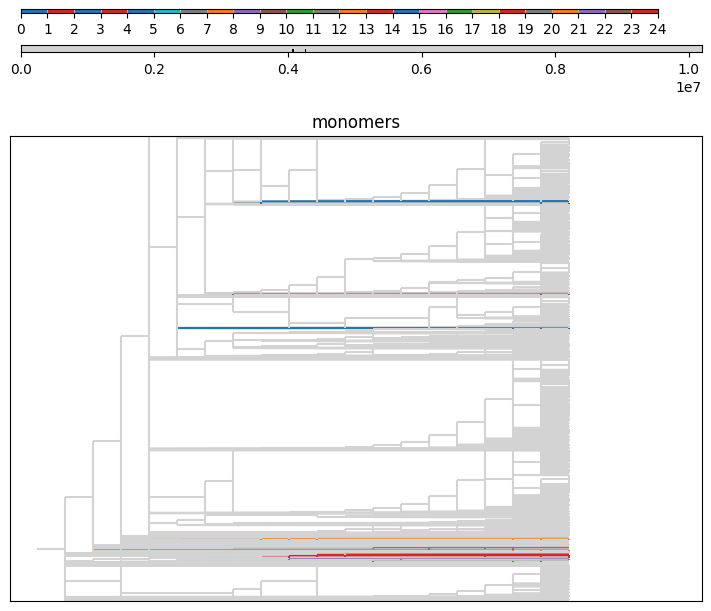

Subtree: [1, 2, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1]


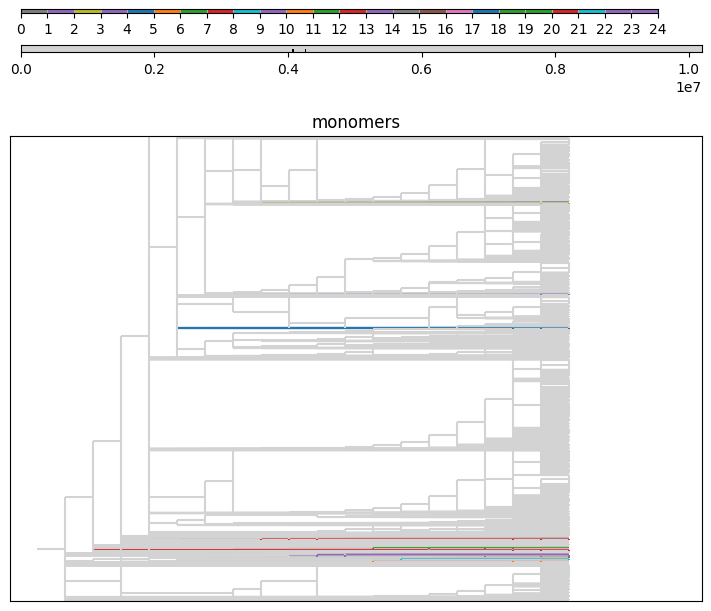

Subtree: [1, 2, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]


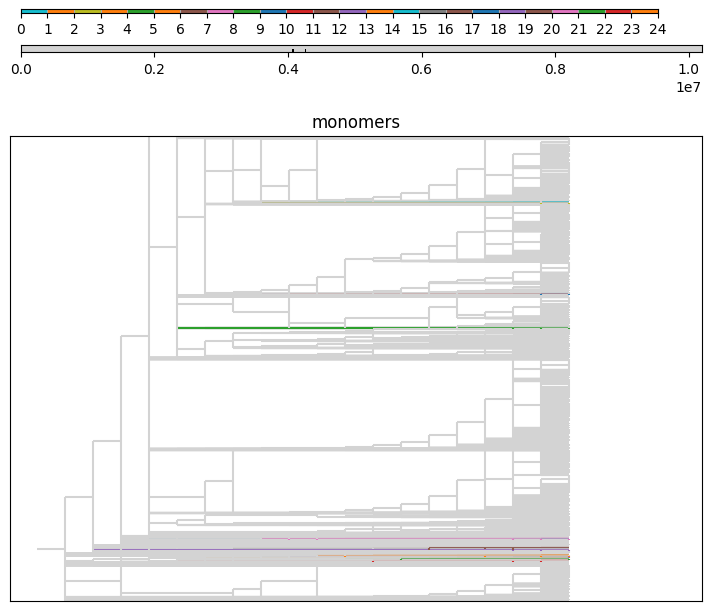

Subtree: [1, 2, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


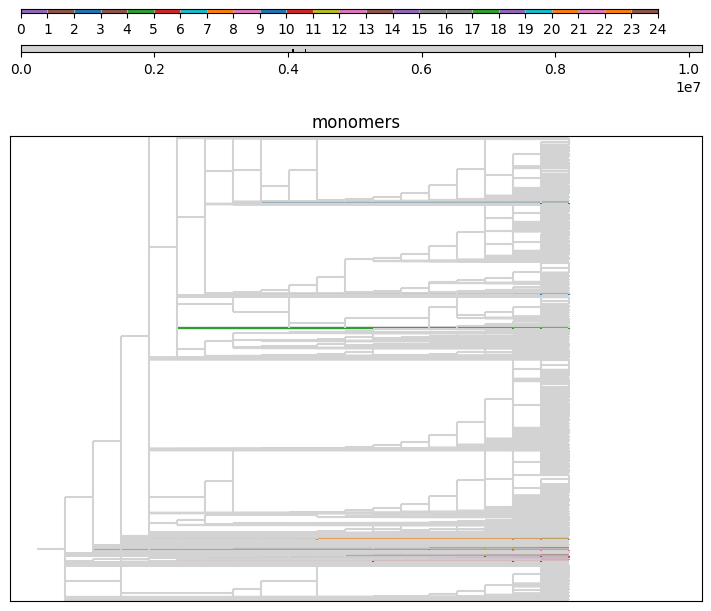

Subtree: [1, 2, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


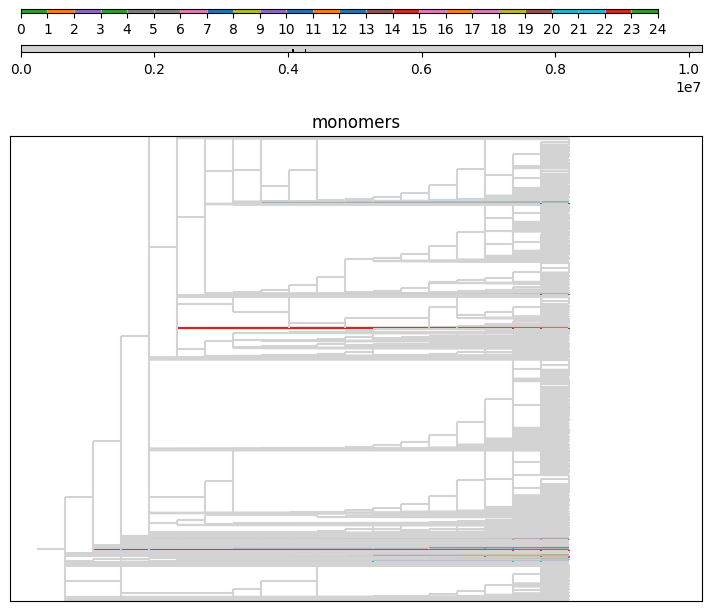

Subtree: [1, 2, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


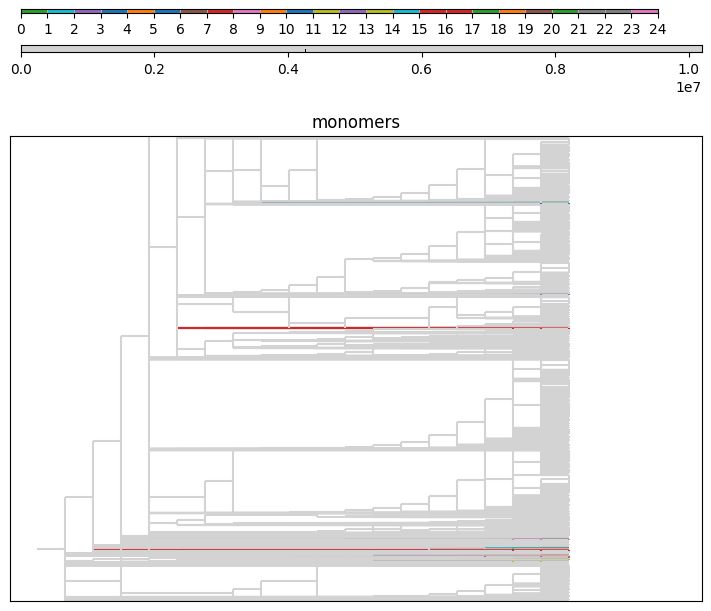

Subtree: [1, 2, 5, 2, 3]


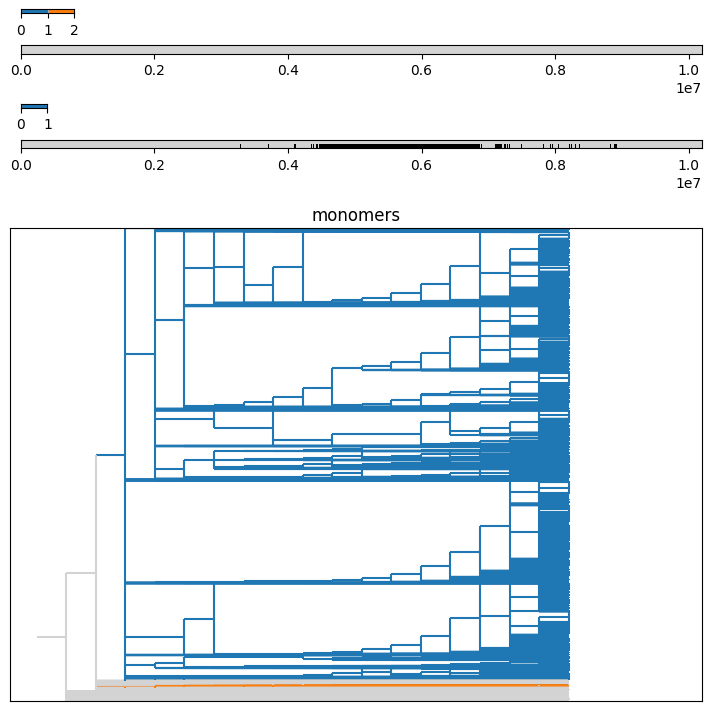

Subtree: [1, 2, 5, 2, 3, 2]


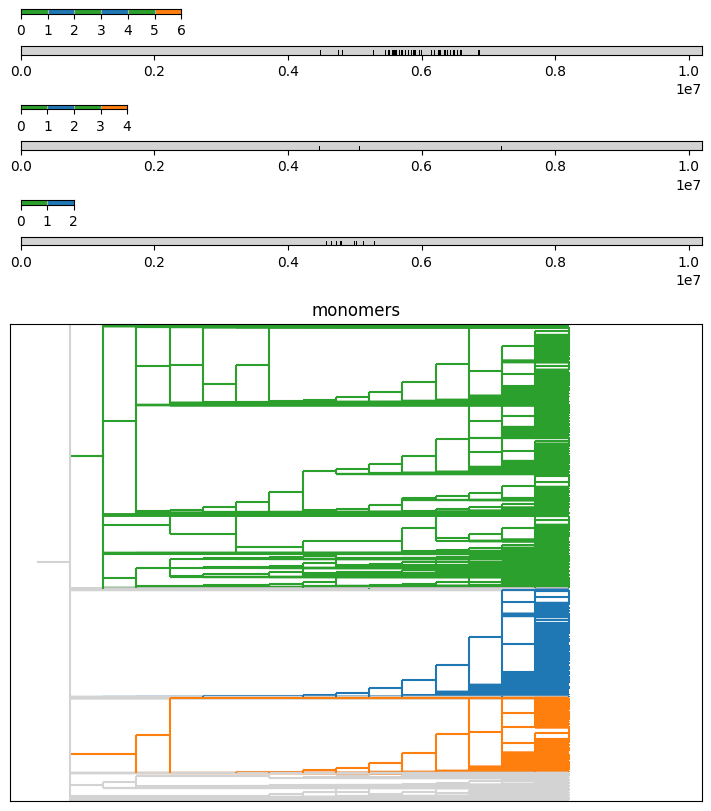

Subtree: [1, 2, 5, 2, 3, 2, 1]


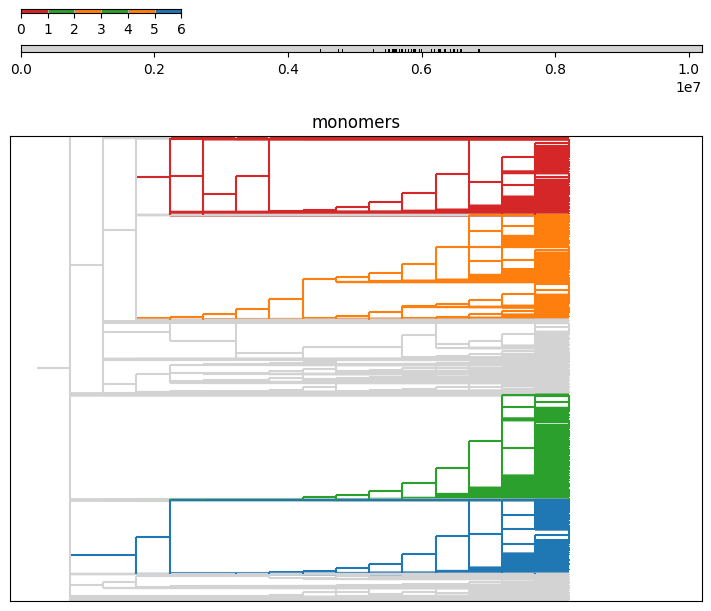

Subtree: [1, 2, 5, 2, 3, 2, 1, 1]


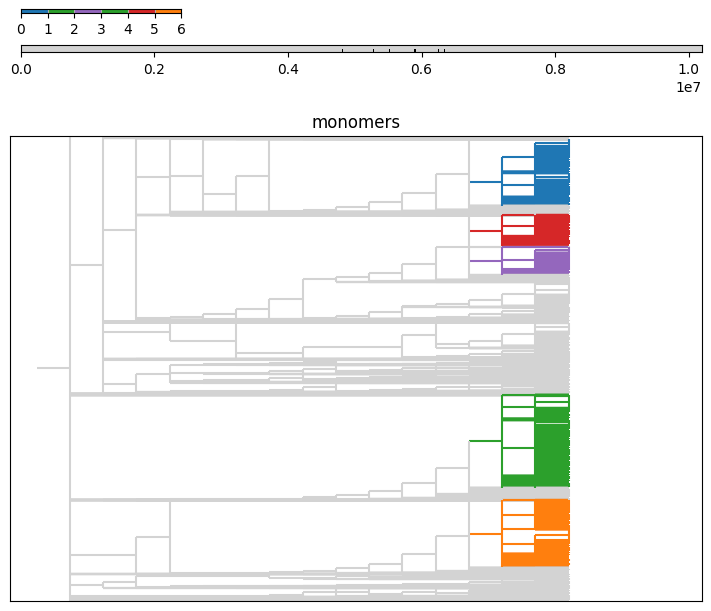

Subtree: [1, 2, 5, 2, 3, 2, 2]


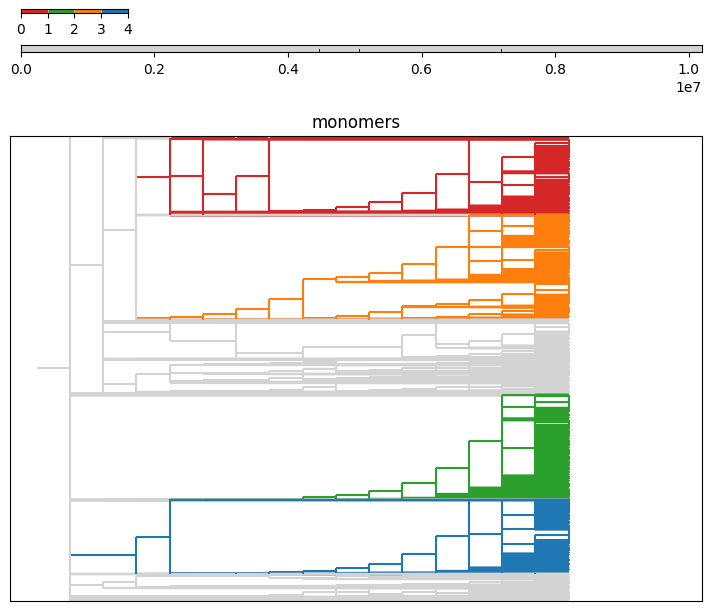

In [23]:
show_hor_tree(hor_tree_root=hor_tree_discrete.as_hor_in_seq, reference_seq=references[reference_seq_id], tree=phylogeny)